# Clusterings
---
From here, we want to determine if there are groups which form in terms of the students based on their response to what motivates them.

In [136]:
# Import the appropriate packages

import json

# Data organization"
import numpy  as np
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', font='Century Gothic')

# Clustering packages
from sklearn               import preprocessing
from sklearn.cluster       import KMeans
from sklearn.decomposition import PCA
from scipy.stats           import pearsonr

# Add hierarchical clustering packages
from scipy.cluster.hierarchy import dendrogram, linkage

In [137]:
# Read in the data
df = pd.read_csv("cleaned_data.csv")

# Get a dataframe of just the questions of motivators
motivator_cols = df.columns[df.columns.str.contains('motivator')].tolist()

motivators = df[motivator_cols]

short_motive_names = motivators.columns.str.replace('motivator_', '')


In [138]:
# Manually create the list of clusters
education_motives = ['motivator_required', 
                    'motivator_choose_not', 
                    'motivator_nervous', 
                    'motivator_difficult']

family_motives = ['motivator_family_continue',
                'motivator_family_encourage',
                'motivator_family_stressed',
                'motivator_family_important']

media_motives = ['motivator_newspapers',
                 'motivator_tv',
                 'motivator_understand',
                 'motivator_speak',
                 'motivator_many']

self_improve_motives = ['motivator_practical',
                        'motivator_career',
                        'motivator_job']

culture_motives = ['motivator_educated',
                   'motivator_converse',
                   'motivator_understand_cultural',
                   'motivator_interact']

citizenship_motives = ['motivator_great',
                       'motivator_communicate',
                       'motivator_natural',
                       'motivator_fluent',
                       'motivator_aspects']

uncategorized_motives = ['motivator_choose',
                         'motivator_friends',
                         'motivator_read']

# Create a dictionary of the clusters
cluster_dict = {'education': education_motives,
                'family': family_motives,
                'media': media_motives,
                'self_improve': self_improve_motives,
                'culture': culture_motives,
                'citizenship': citizenship_motives,
                'uncategorized': uncategorized_motives}

# Export the dictionary to a JSON
with open('motivator_clusters.json', 'w') as fp:
    json.dump(cluster_dict, fp)

# Principal Component Analysis
---
PCA is a form of statistical modeling which reduces helps to reduce the dimensionality of the data by applying Matrix Operations to create vectors of the linear combination of parameters (in our case, motivators) which explain as much variability of the data as it cans. 

Each Principal Component explains a proportion of the variability (meaning this feature accounts for the much change of the data) in decreasing fashion so Principal Component 1 is guaranteed to contain the most amount of variability and so on.

#### Group of Participants
---
We will now conduct clustering on our participants to see the groups which arise from there and see how their responses align within these groups.

In [139]:
# Scale the data without transposing
motivators_scaled = preprocessing.scale(motivators)

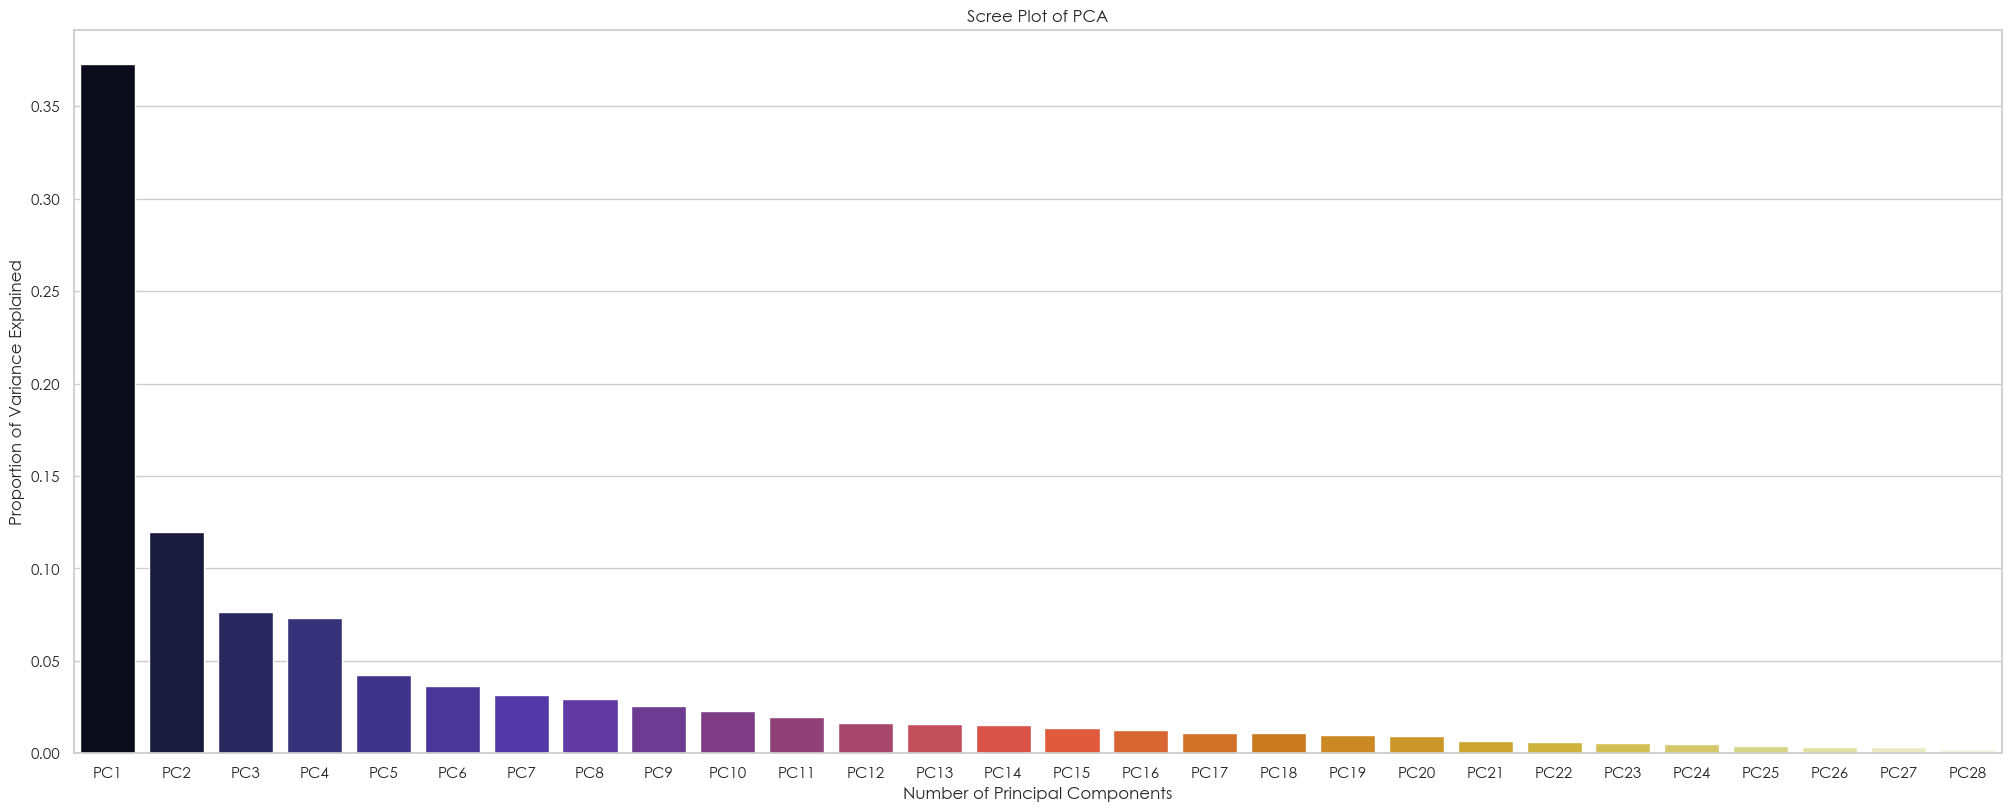

In [140]:
# Fit the PCA object to the data
pca_motivators = PCA()
pca_motivators.fit(motivators_scaled)

# Transform the data
motivators_pca = pca_motivators.transform(motivators_scaled)

# Get the variance ratio
variance_ratio = pca_motivators.explained_variance_ratio_
pca_labels = ['PC' + str(i) for i in range(1, len(variance_ratio) + 1)]

# Plot the explained variance ratio
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
sns.barplot(x=pca_labels, y=variance_ratio, palette='CMRmap')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot of PCA')
plt.show()

In [141]:
# Calculate how many components are needed to explain 90% of the variance
cumulative_variance = np.cumsum(variance_ratio)
print('Number of components needed to explain 70% of the variance: {}'.format(np.argmax(cumulative_variance >= 0.70) + 1))

Number of components needed to explain 70% of the variance: 6


In [142]:
# Create a dataframe of PCA loadings for the participants
motivators_loadings = pd.DataFrame(motivators_pca, columns=pca_labels)

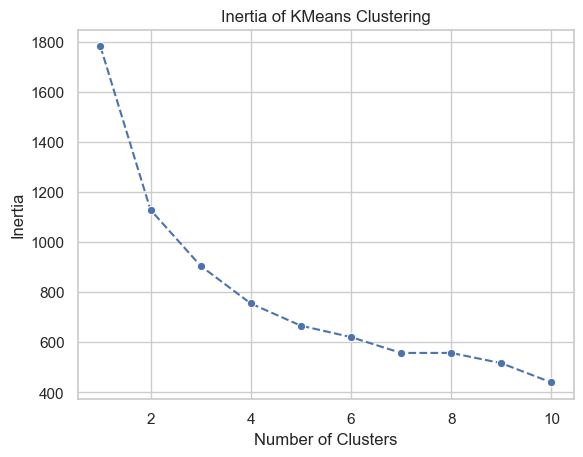

In [143]:
sns.set(style='whitegrid')

# Conduct a KMeans clustering analysis
ppt_inertia = []
ppt_kmeans = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(motivators_pca[:, :5])
    ppt_kmeans.append(kmeans)
    ppt_inertia.append(kmeans.inertia_)

# Plot the inertia
sns.lineplot(x=range(1, 11), y=ppt_inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans Clustering')
plt.show()

In [144]:
# Create a dataframe containing only 6 clusters
ppt_kmeans6 = motivators_loadings.copy()

ppt_kmeans6['Cluster'] = ppt_kmeans[5].labels_ + 1

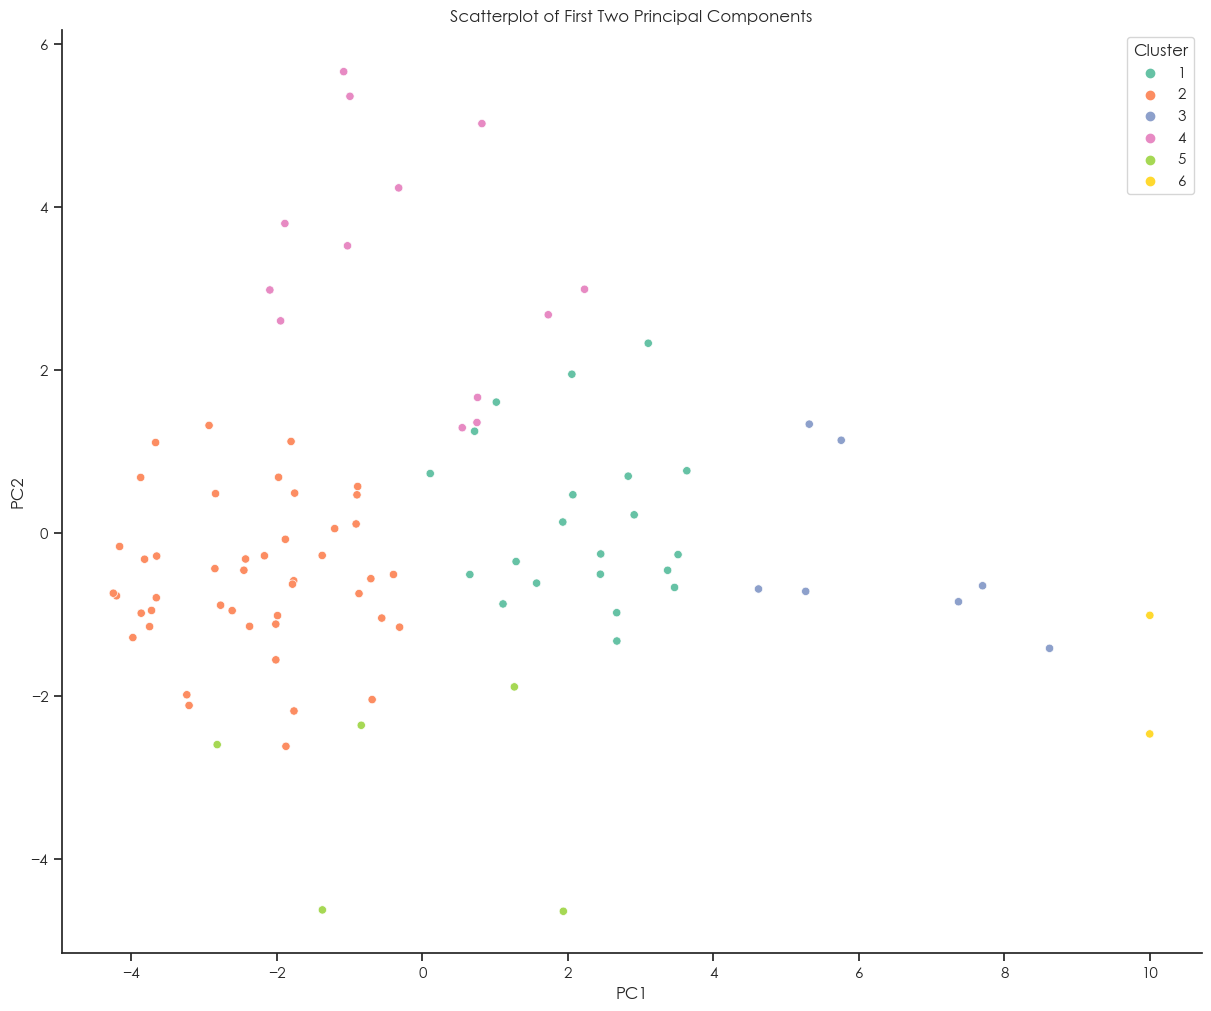

In [145]:
custom_style = {"axes.spines.right": False, "axes.spines.top": False, 
                "font.family": ['sans-serif'], "font.sans-serif": ['Century Gothic']}
sns.set_style("ticks", rc=custom_style)

# Plot a scatterplot of the first two principal components
min_val = ppt_kmeans6['PC1'].min()

fig, ax = plt.subplots(figsize=(12, 10), constrained_layout=True)
sns.scatterplot(x='PC1', y='PC2', data=ppt_kmeans6, hue='Cluster', palette='Set2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of First Two Principal Components')
plt.show()

In [146]:
# Place the cluster label on the original dataframe
orig_df = df.copy()

orig_df['Cluster'] = ppt_kmeans6['Cluster']

In [147]:
# Create a list of the motivation ranks
motivation_ranks = ['rank_family', 'rank_media', 'rank_education', 
                    'rank_culture', 'rank_improvement', 'rank_citizenship']

In [148]:
# Melt the dataframe down to long format
orig_df_melt = pd.melt(orig_df, id_vars=['Cluster'], value_vars=motivation_ranks)

# Rename the variables column
orig_df_melt.rename(columns={'variable': 'Motivation', 'value': 'Rank'}, inplace=True)

# Rename the values within the motivation column
orig_df_melt['Motivation'].replace({'rank_family': 'Family', 'rank_media': 'Media',
                                    'rank_culture': 'Culture', 'rank_improvement': 'Improvement',
                                    'rank_citizenship': 'Citizenship', 'rank_education': 'Education'}, inplace=True)

In [149]:
# Keep only the first clusters 
orig_df_short_first = orig_df_melt[orig_df_melt['Cluster'] <= 3]

# Keep the last clusters
orig_df_short_last = orig_df_melt[orig_df_melt['Cluster'] > 3]

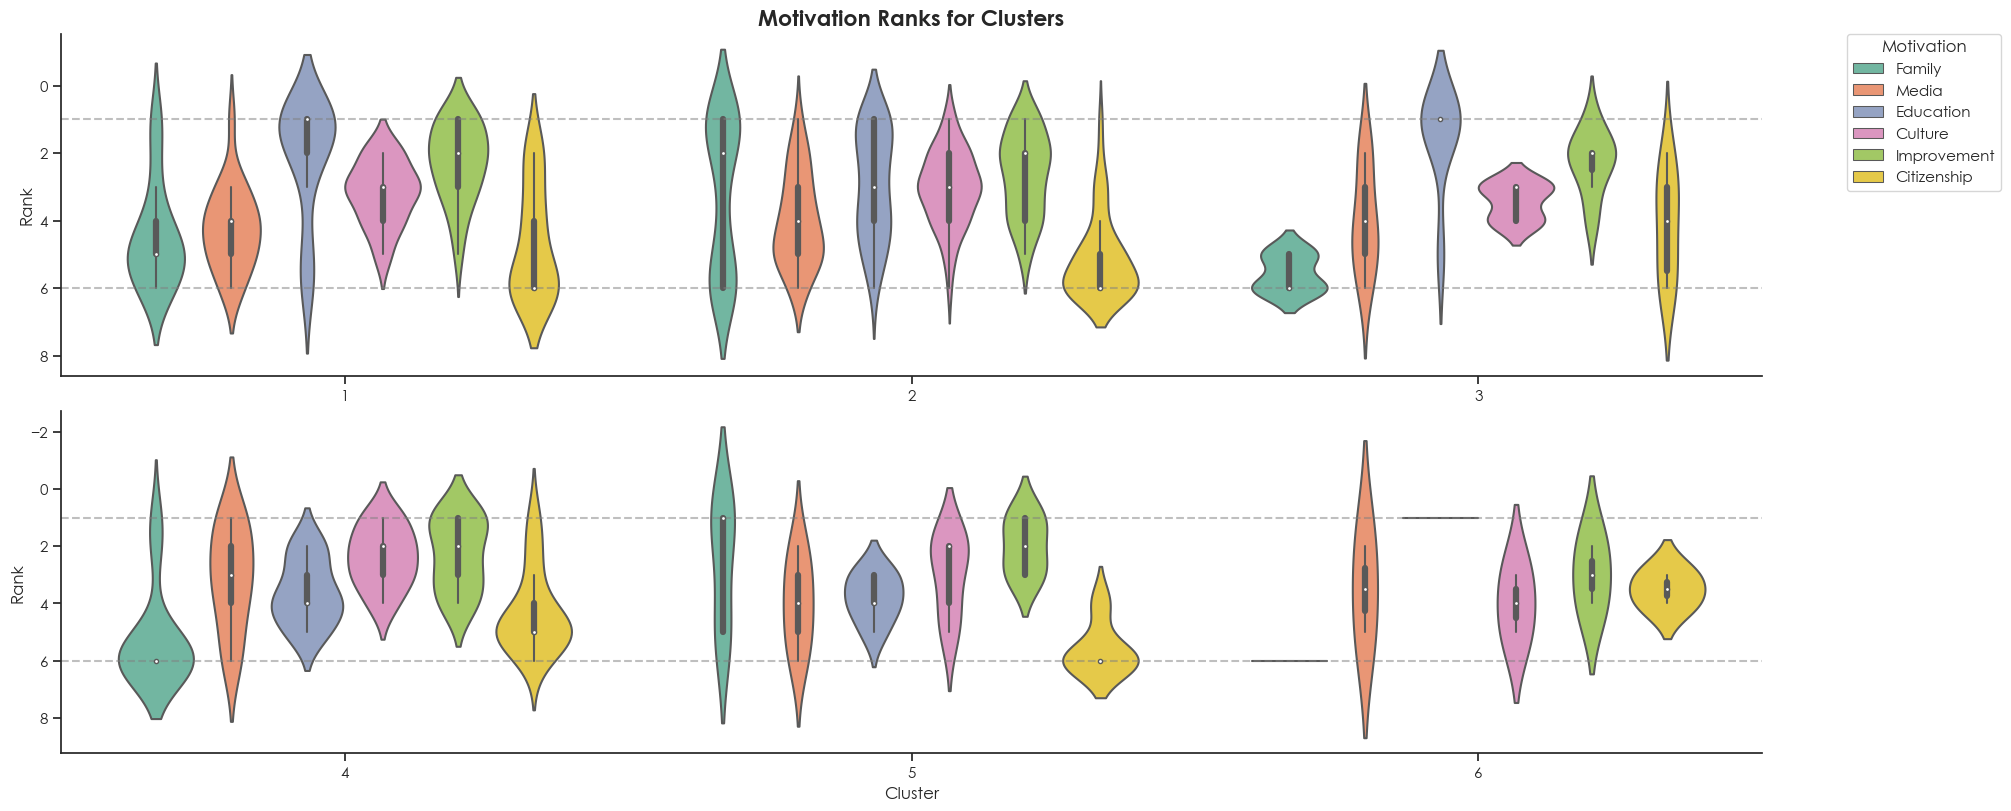

In [150]:
custom_style = {"axes.spines.right": False, "axes.spines.top": False, 
                "font.family": ['sans-serif'], "font.sans-serif": ['Century Gothic']}
sns.set_style("ticks", rc=custom_style)

fig, ax = plt.subplots(2, 1, figsize=(20, 8), constrained_layout=True)


# Plot the first clusters
sns.violinplot(x='Cluster', y='Rank', data=orig_df_short_first, hue='Motivation', palette='Set2', ax=ax[0])

# Add dashed line at y = 1 and y = 6
ax[0].axhline(y=1, linestyle='--', color='grey', alpha=0.5)
ax[0].axhline(y=6, linestyle='--', color='grey', alpha=0.5)

ax[0].set_title('Motivation Ranks for Clusters', fontsize=16, fontweight='bold')
ax[0].set_xlabel('')
ax[0].set_ylabel('Rank')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Motivation')

# Plot the last clusters
sns.violinplot(x='Cluster', y='Rank', data=orig_df_short_last, hue='Motivation', palette='Set2', ax=ax[1])
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Rank')
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# Hide the legend
ax[1].legend().set_visible(False)

# Add dashed line at y = 1 and y = 6
ax[1].axhline(y=1, linestyle='--', color='grey', alpha=0.5)
ax[1].axhline(y=6, linestyle='--', color='grey', alpha=0.5)

# Reverse the order of the y-axis
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

In [151]:
def makeBoxplots(
    df: pd.DataFrame, 
    motives: list[str],
    cluster: str,
    title: str,
    axes: plt.Axes,
    color: str
):
    '''
    Creates boxplots of the motivation ranks for each cluster.
    
    Parameters
    ----------
    df : DataFrame
        The dataframe containing the motivation ranks and clusters.
    motives : list[str]
        List of relevant motivators.
    title : str
        The title of the plot.
    ax : matplotlib.axes
        The axes to plot the boxplot on.
    color : str
        Singular color to use for the boxplot.
    '''
    # Keep the rows which match the cluster
    temp_df = df[df['Cluster'] == cluster]

    # Melt the dataframe down to long format
    cluster_df_melt = pd.melt(temp_df, id_vars=['Cluster'], value_vars=motives)
    
    # Rename the variables column
    cluster_df_melt.rename(columns={'variable': 'Motivation', 'value': 'Response'}, inplace=True)
    
    # Remove 'motivator_' from the values in the motivation column
    cluster_df_melt['Motivation'] = cluster_df_melt['Motivation'].str.replace('motivator_', '')

    # Create a boxplot
    sns.boxplot(x='Motivation', 
                y='Response', 
                data=cluster_df_melt,
                ax=axes,
                color=color)
    
    axes.set_title(title, fontsize=16, fontweight='bold')
    axes.set_xlabel('')
    axes.set_ylabel('Response')

    # Set the y-axis limits
    axes.set_ylim(-1, 11)

    # Rotate the x-axis labels
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')

In [152]:
# Assign the colors to the motives as they appear in Seaborn Color Palette Set2
family_color = sns.color_palette('Set2')[0]
media_color = sns.color_palette('Set2')[1]
education_color = sns.color_palette('Set2')[2]
culture_color = sns.color_palette('Set2')[3]
improvement_color = sns.color_palette('Set2')[4]
citizenship_color = sns.color_palette('Set2')[5]
other_color = sns.color_palette('Set2')[6]

### More Nuanced Ranks per Cluster
---
The following graphs detail how individuals within each cluster responded on each individual motivator question.

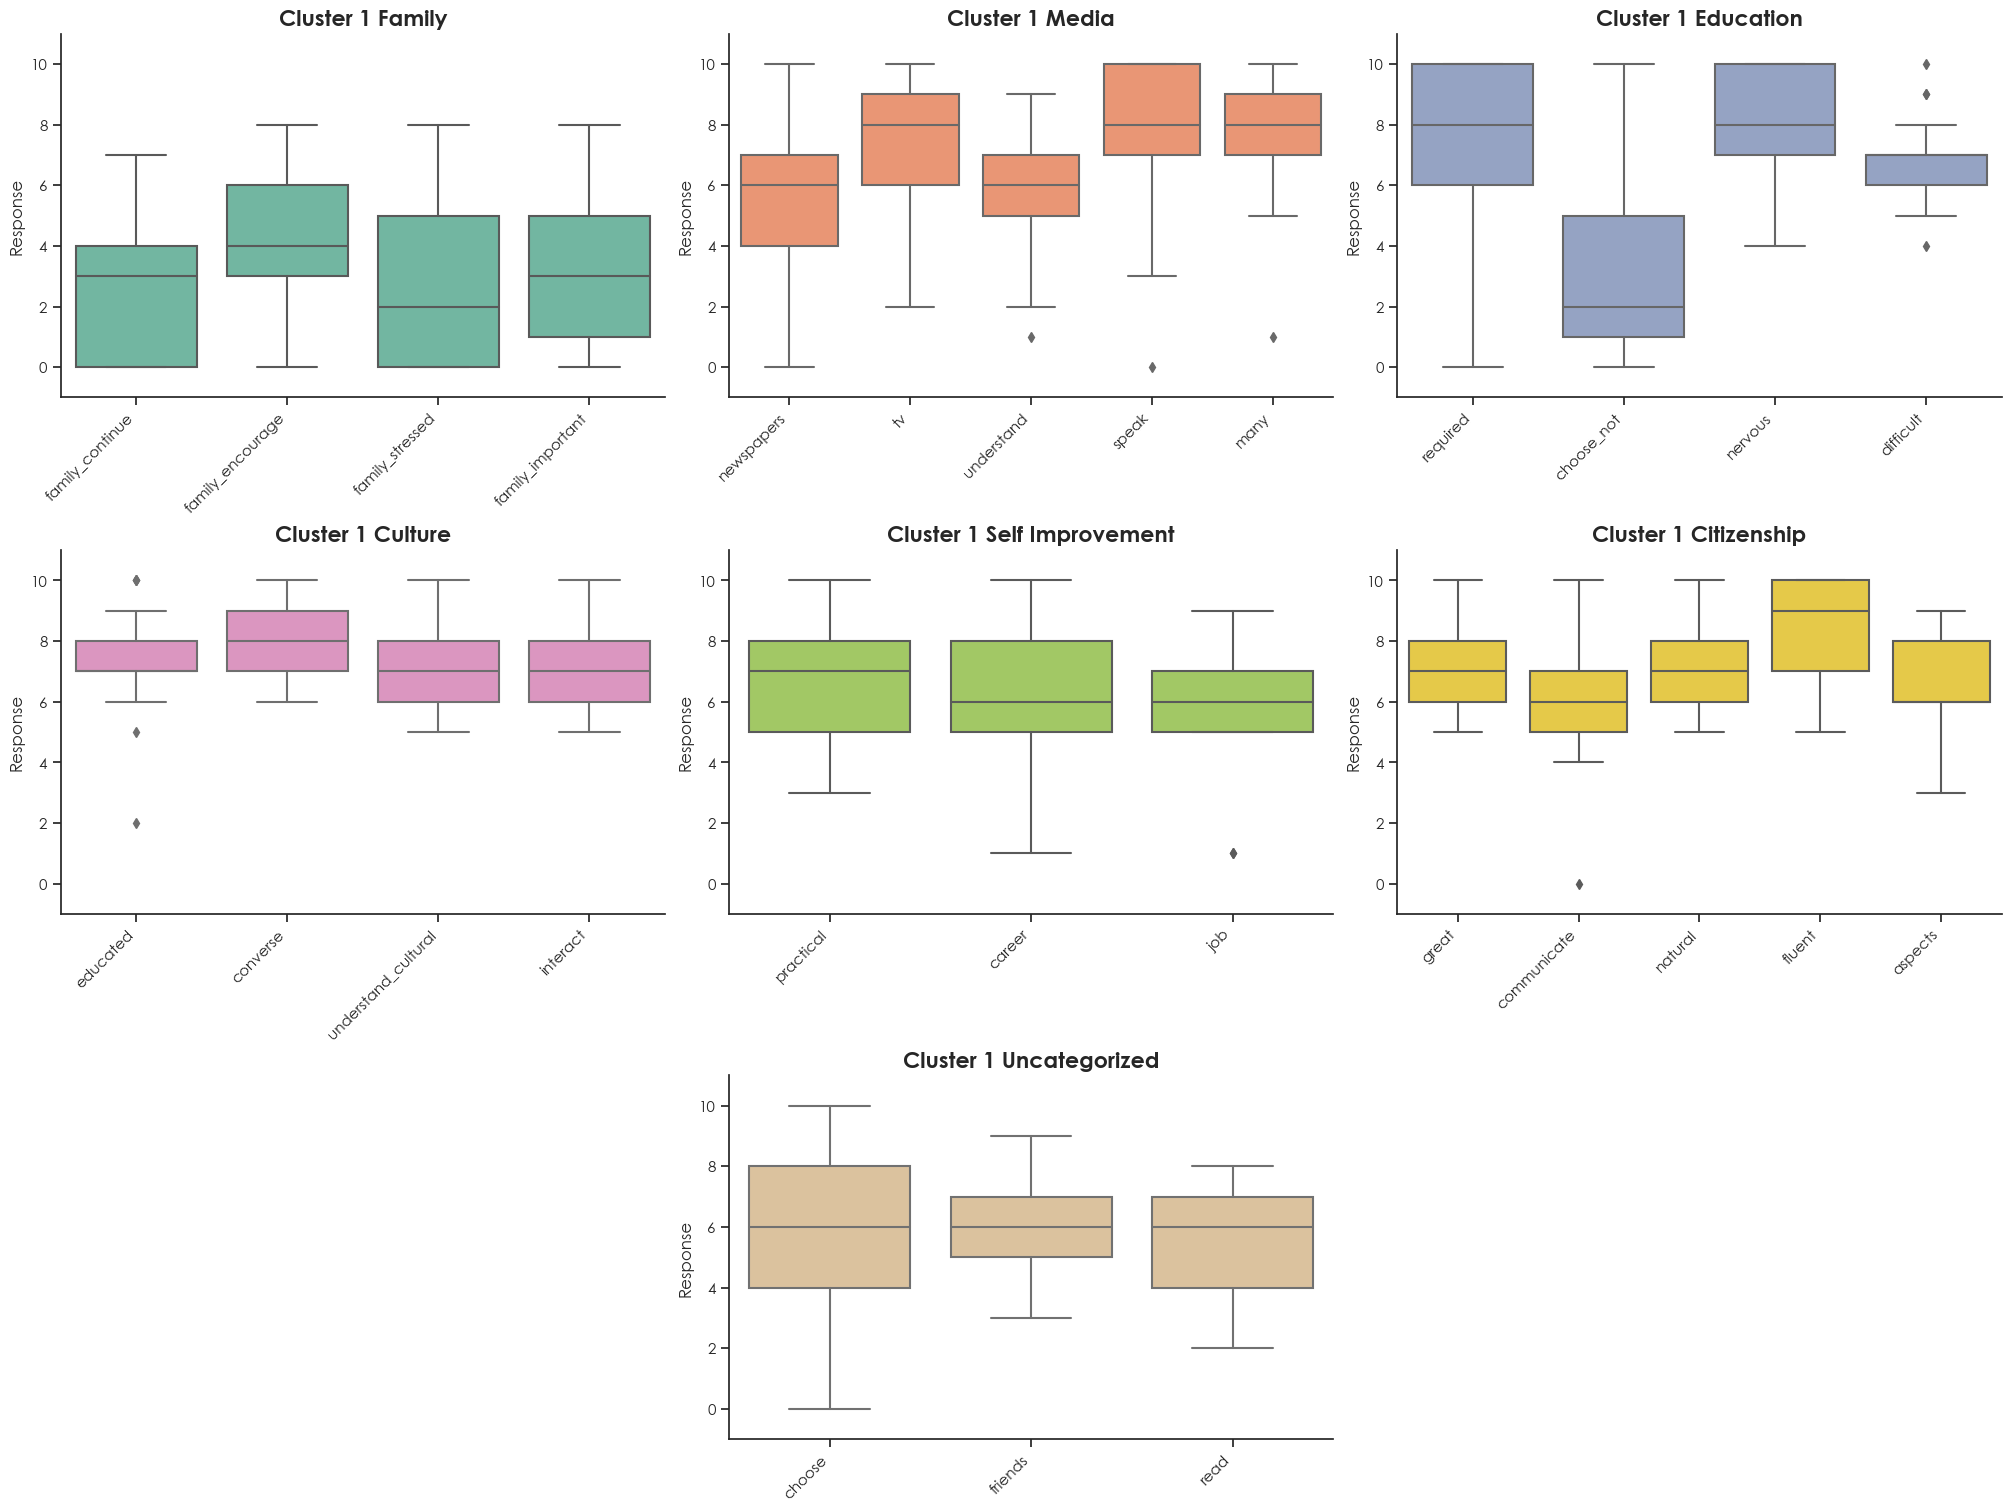

In [153]:
# Create the figures for cluster 1
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

makeBoxplots(orig_df, family_motives, 1, 'Cluster 1 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 1, 'Cluster 1 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 1, 'Cluster 1 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 1, 'Cluster 1 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 1, 'Cluster 1 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 1, 'Cluster 1 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 1, 'Cluster 1 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()

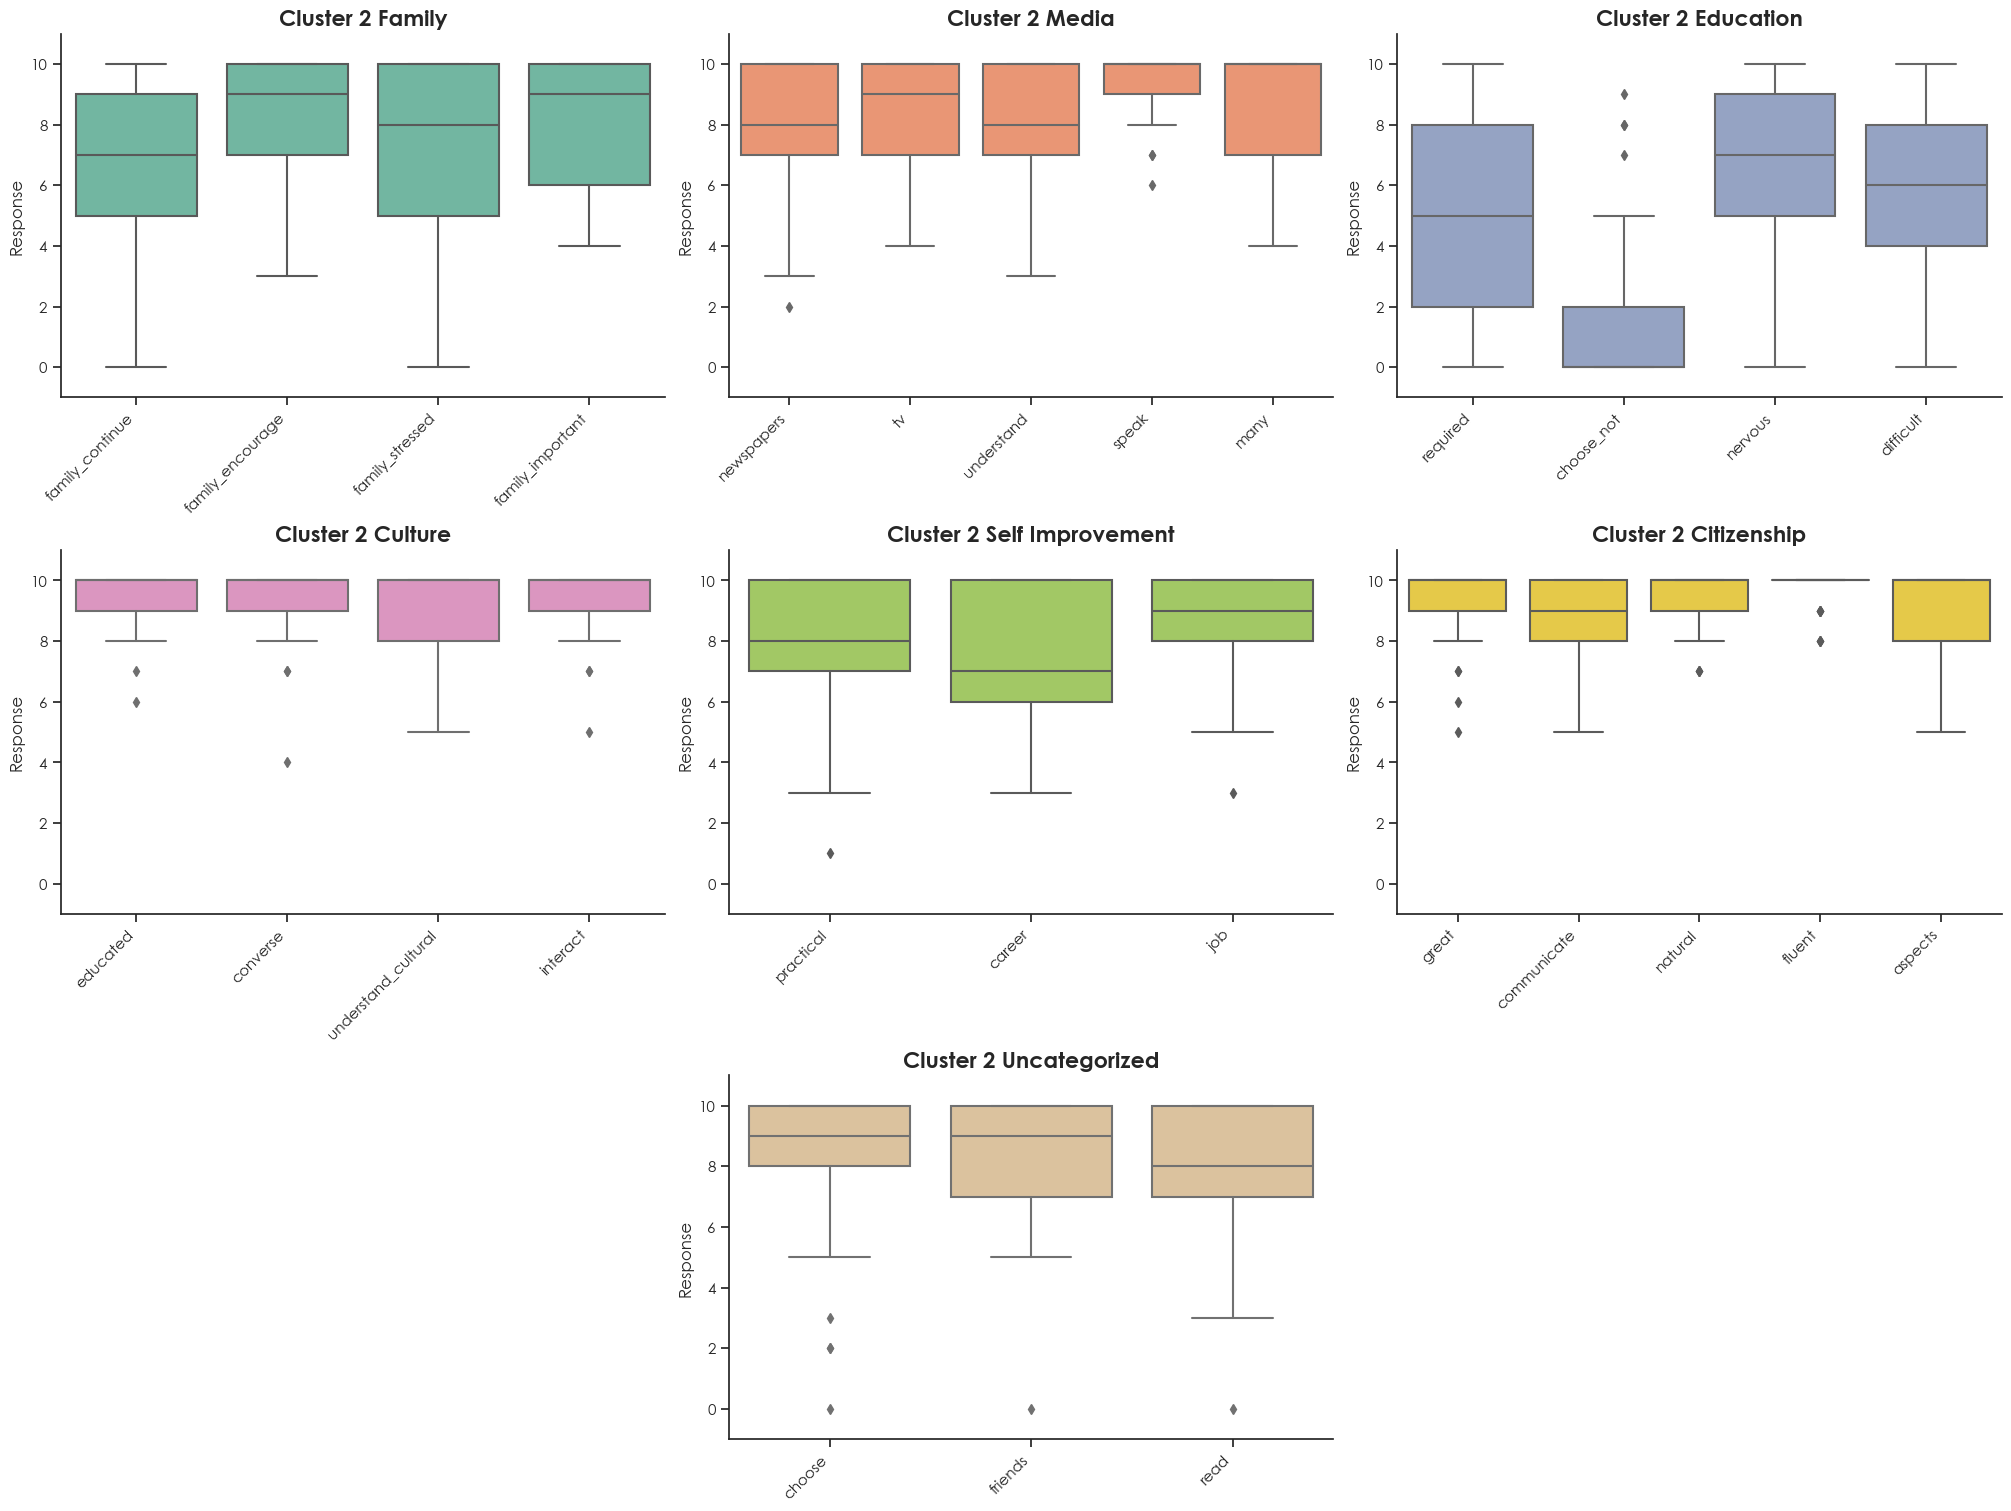

In [154]:
# Create the figures for cluster 2
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

makeBoxplots(orig_df, family_motives, 2, 'Cluster 2 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 2, 'Cluster 2 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 2, 'Cluster 2 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 2, 'Cluster 2 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 2, 'Cluster 2 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 2, 'Cluster 2 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 2, 'Cluster 2 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()


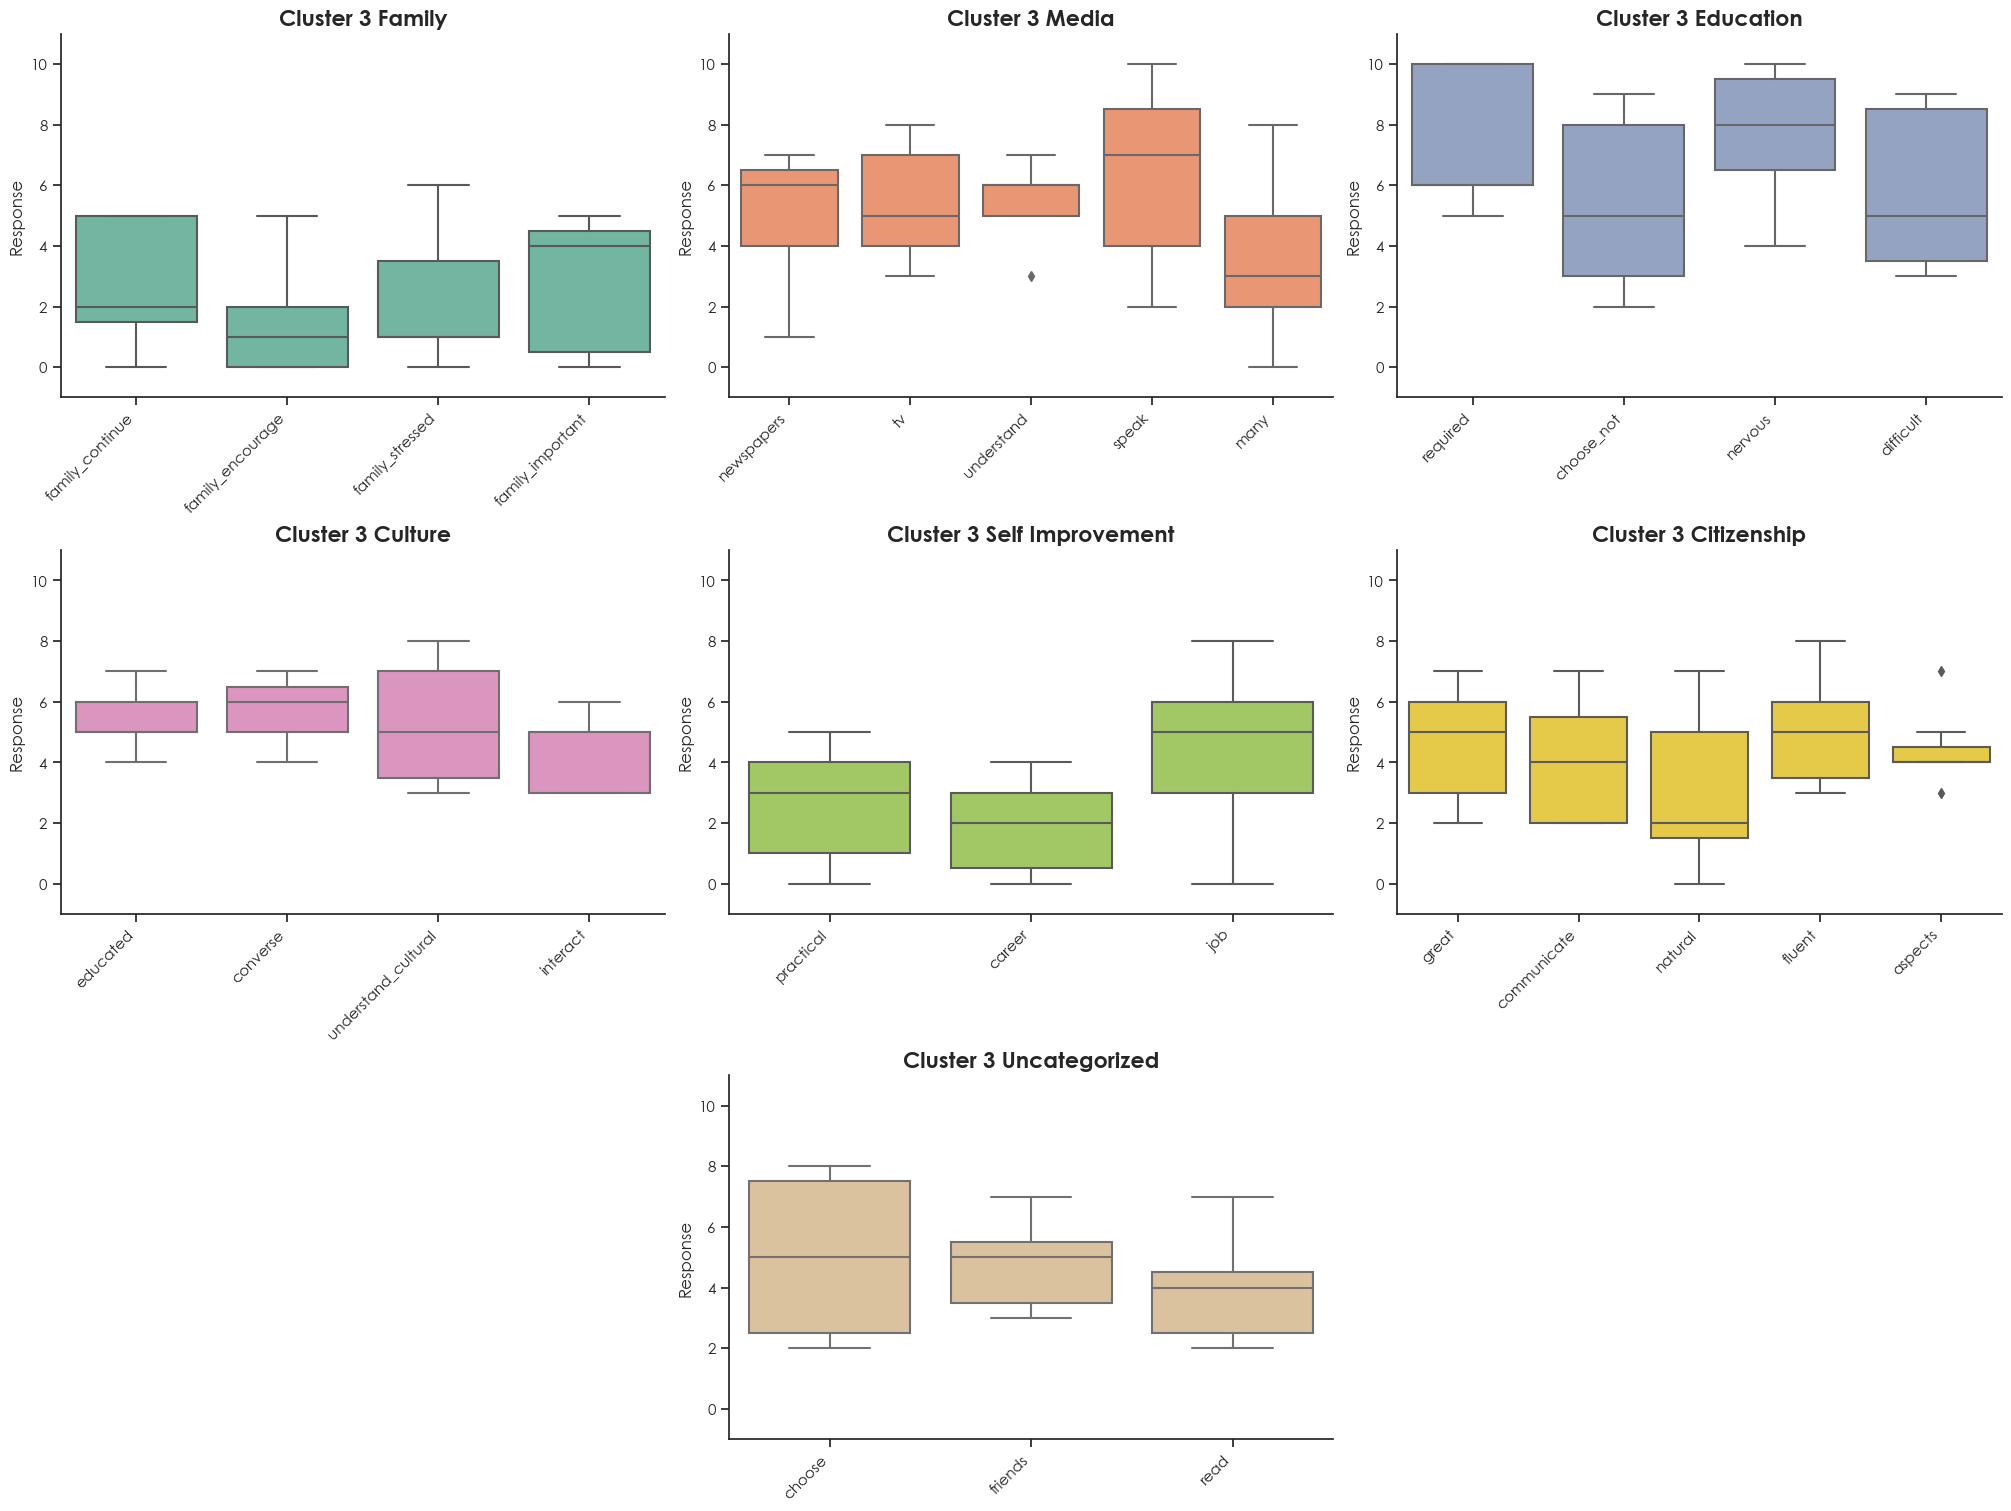

In [155]:
# Create the figures for cluster 3
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

color = sns.color_palette('Set2')[2]

makeBoxplots(orig_df, family_motives, 3, 'Cluster 3 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 3, 'Cluster 3 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 3, 'Cluster 3 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 3, 'Cluster 3 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 3, 'Cluster 3 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 3, 'Cluster 3 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 3, 'Cluster 3 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()

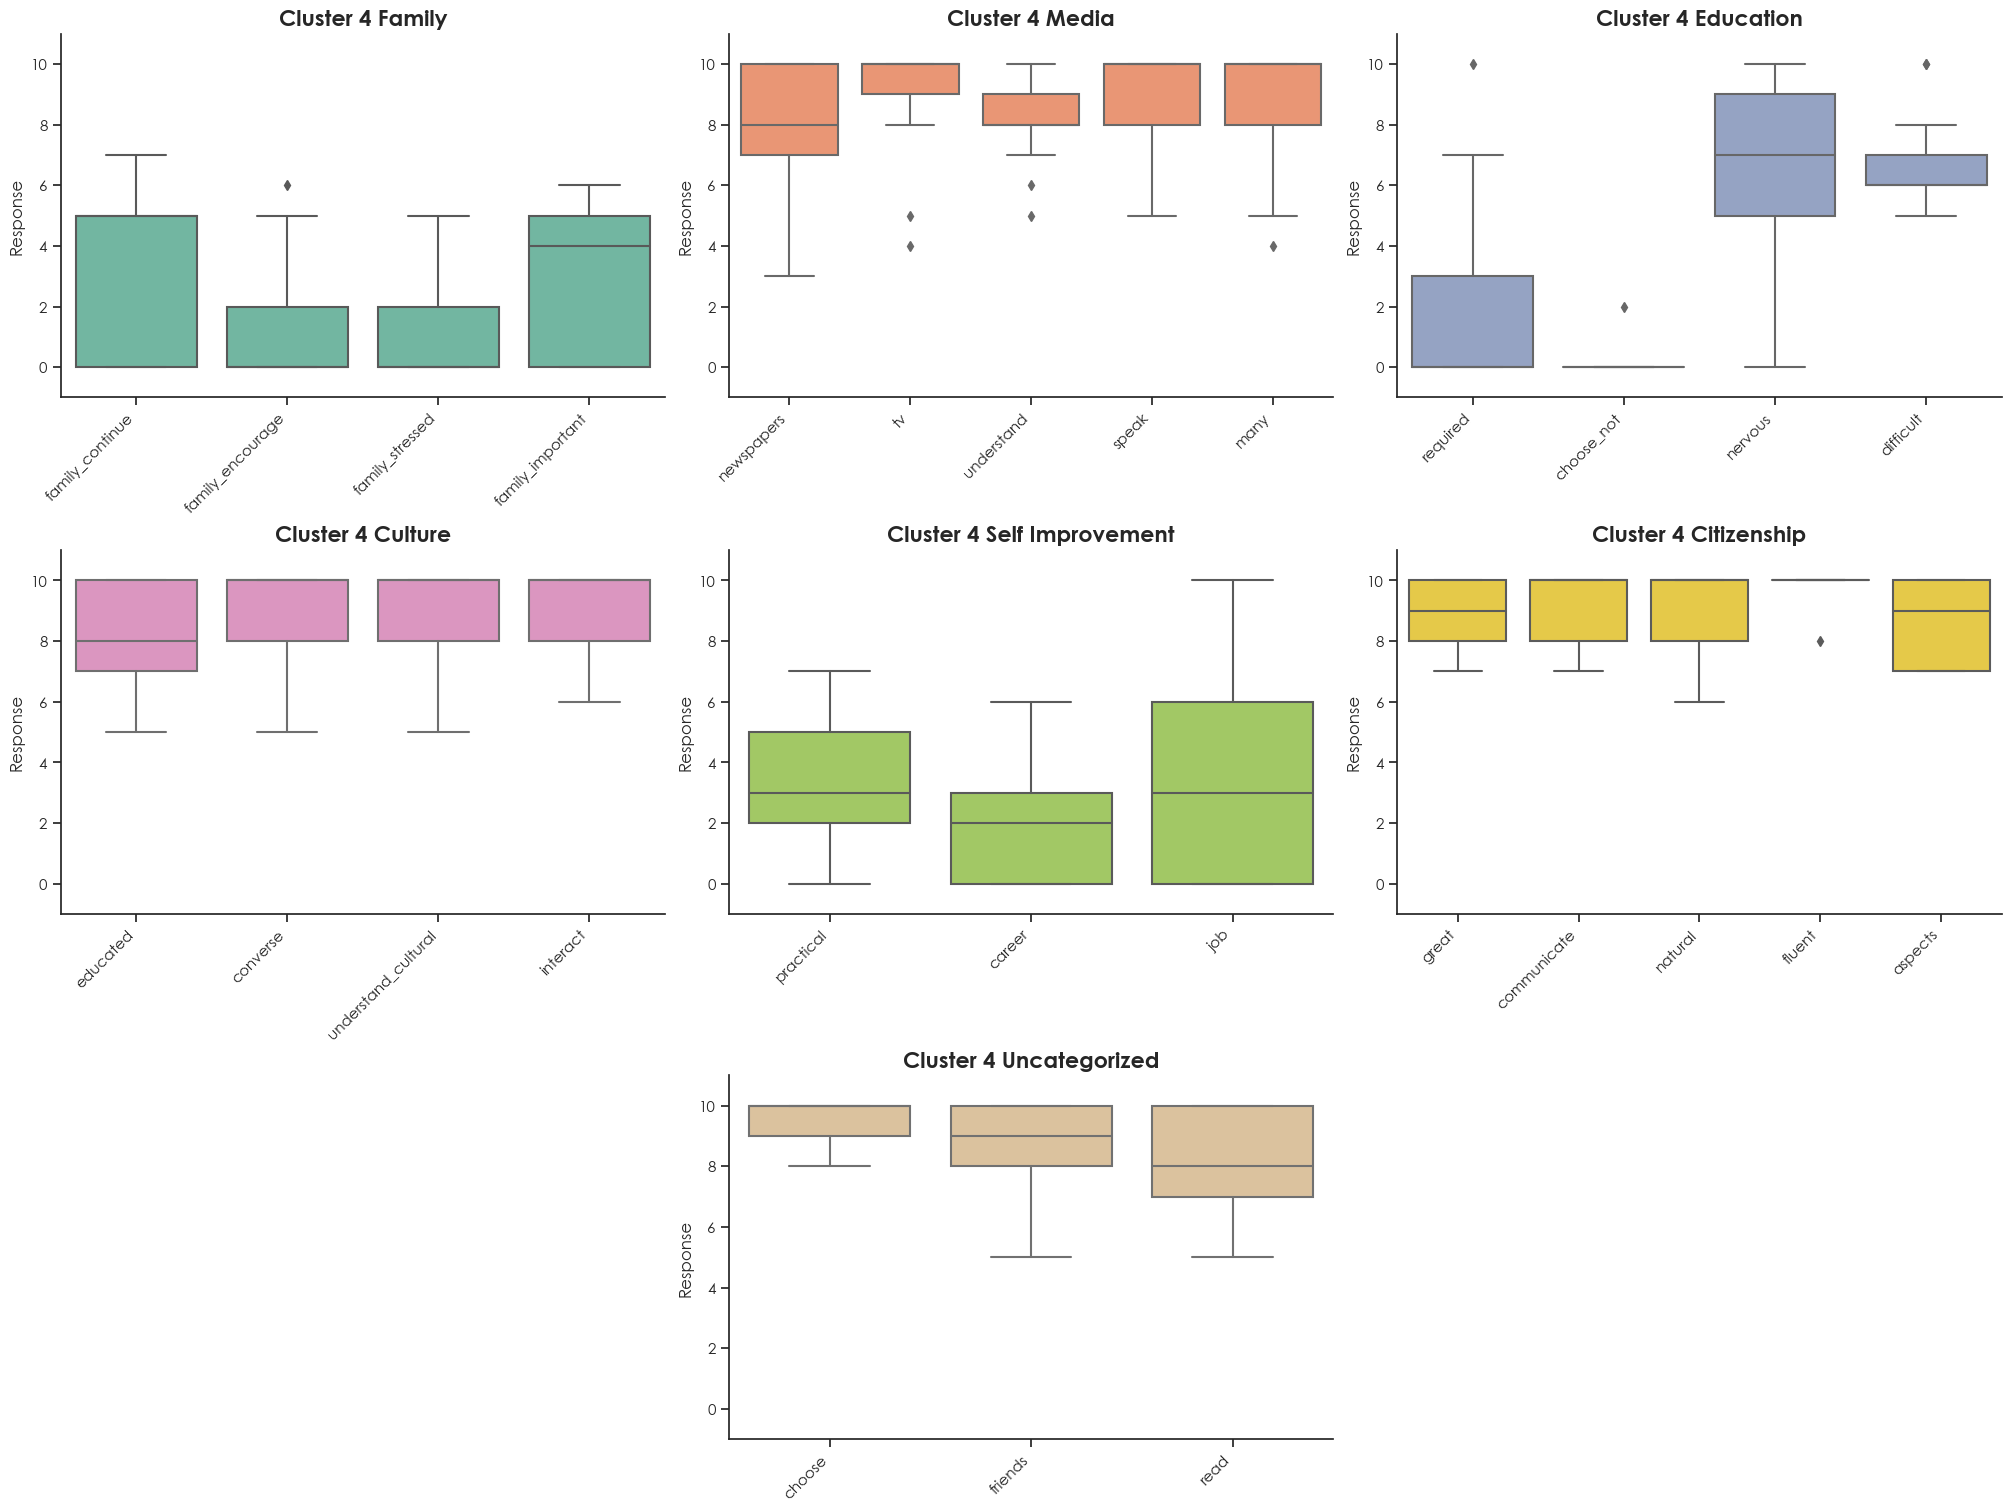

In [156]:
# Create the figures for cluster 4
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

makeBoxplots(orig_df, family_motives, 4, 'Cluster 4 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 4, 'Cluster 4 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 4, 'Cluster 4 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 4, 'Cluster 4 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 4, 'Cluster 4 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 4, 'Cluster 4 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 4, 'Cluster 4 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()

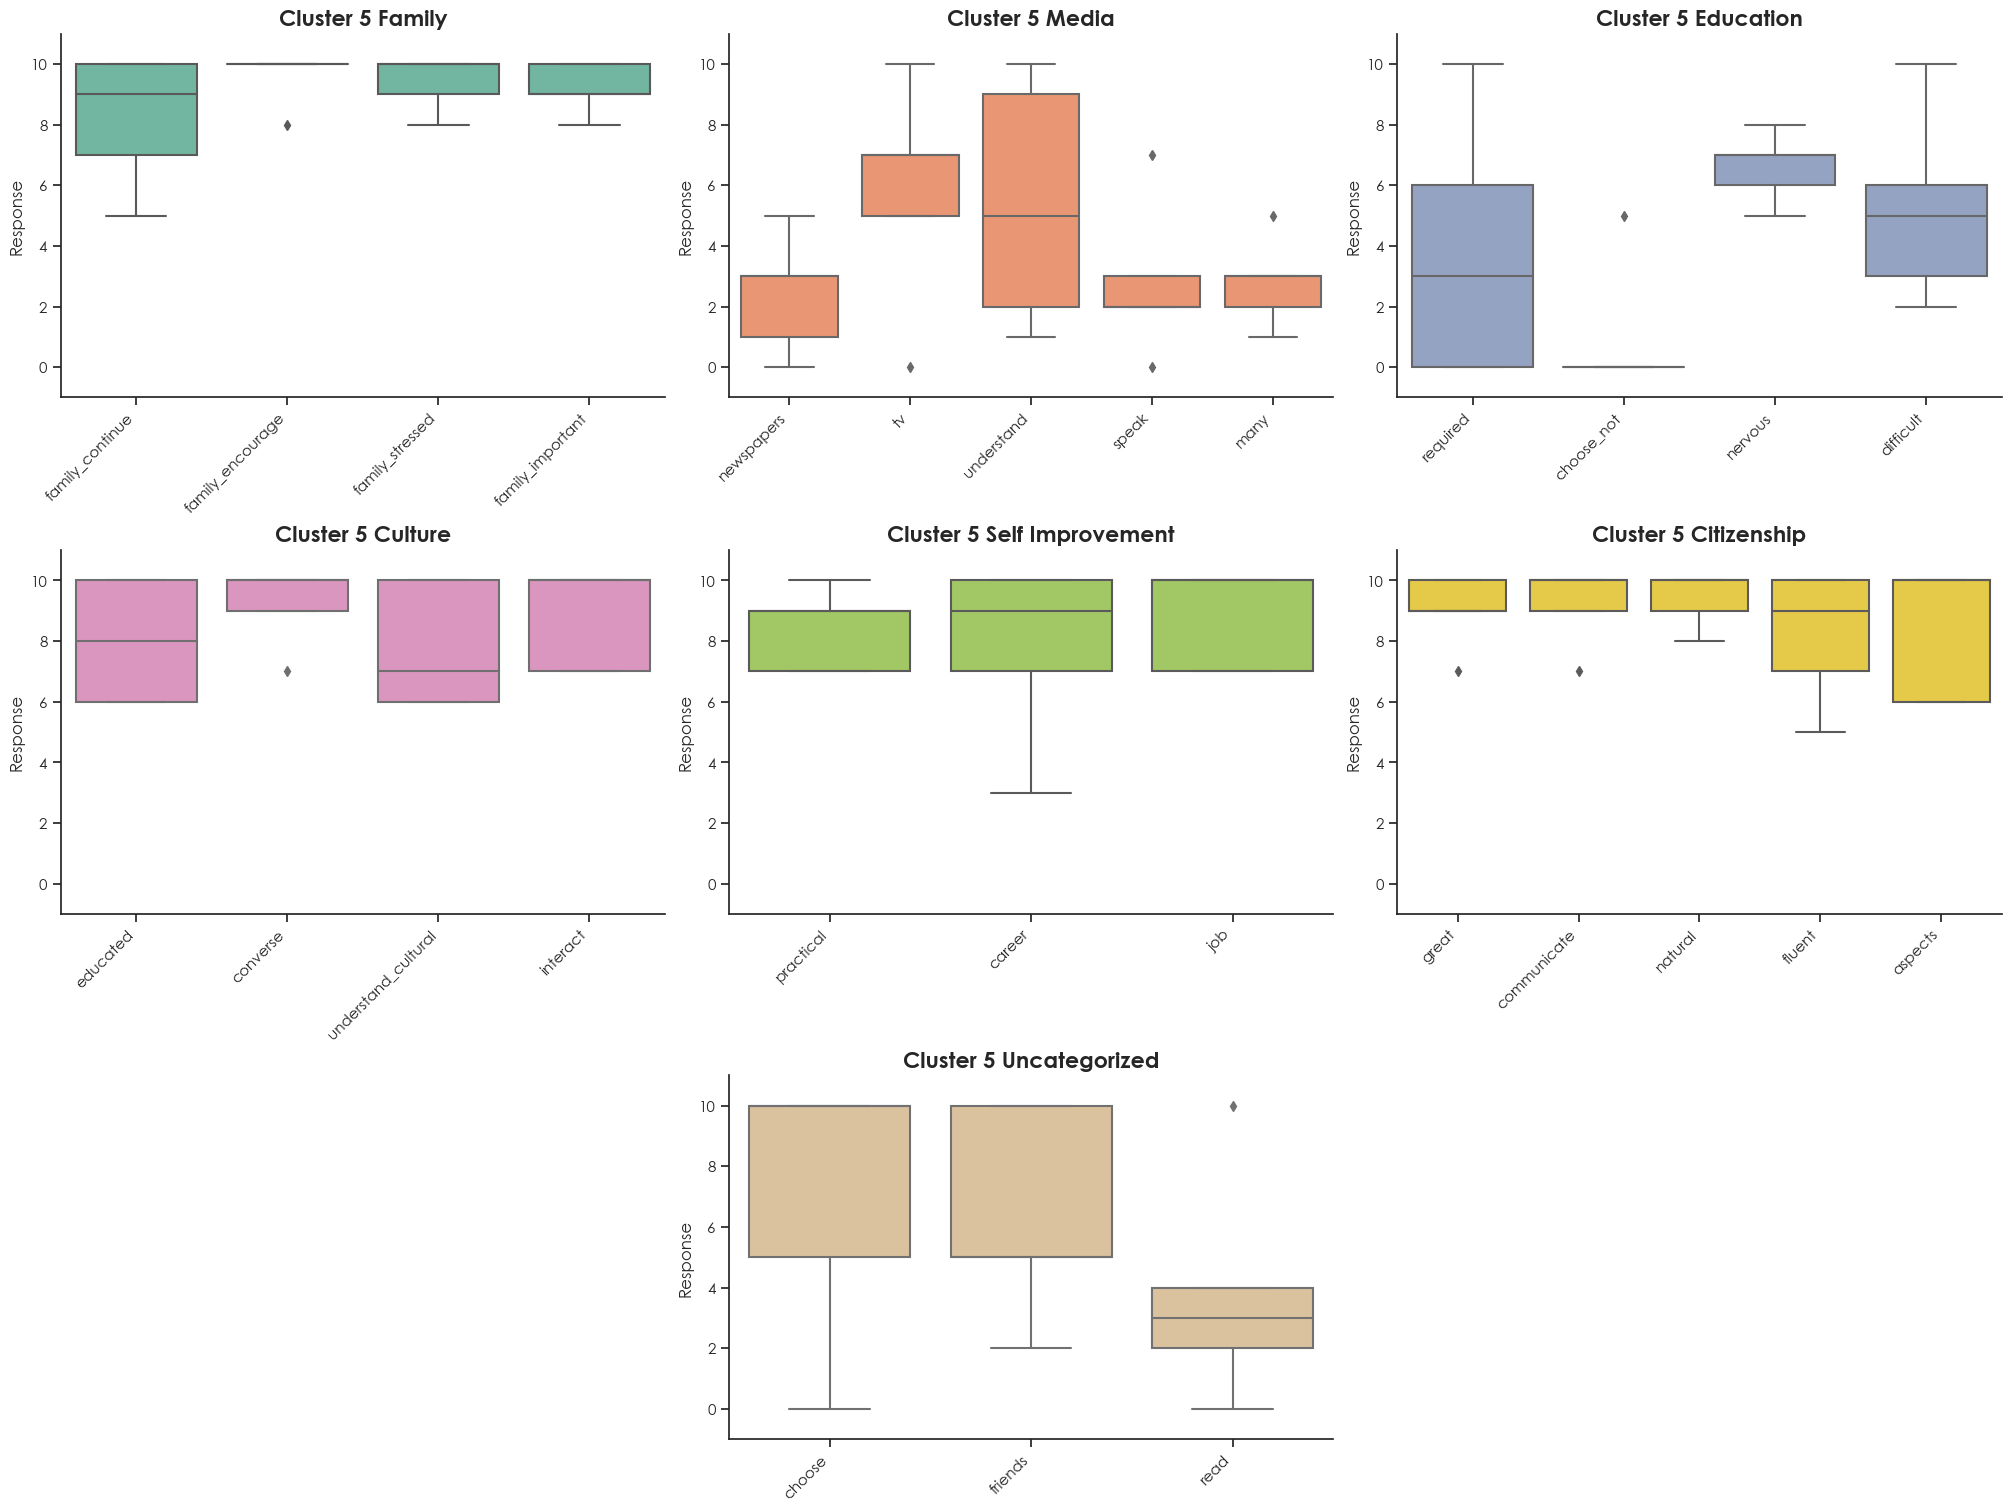

In [157]:
# Create the figures for cluster 5
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

makeBoxplots(orig_df, family_motives, 5, 'Cluster 5 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 5, 'Cluster 5 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 5, 'Cluster 5 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 5, 'Cluster 5 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 5, 'Cluster 5 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 5, 'Cluster 5 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 5, 'Cluster 5 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()

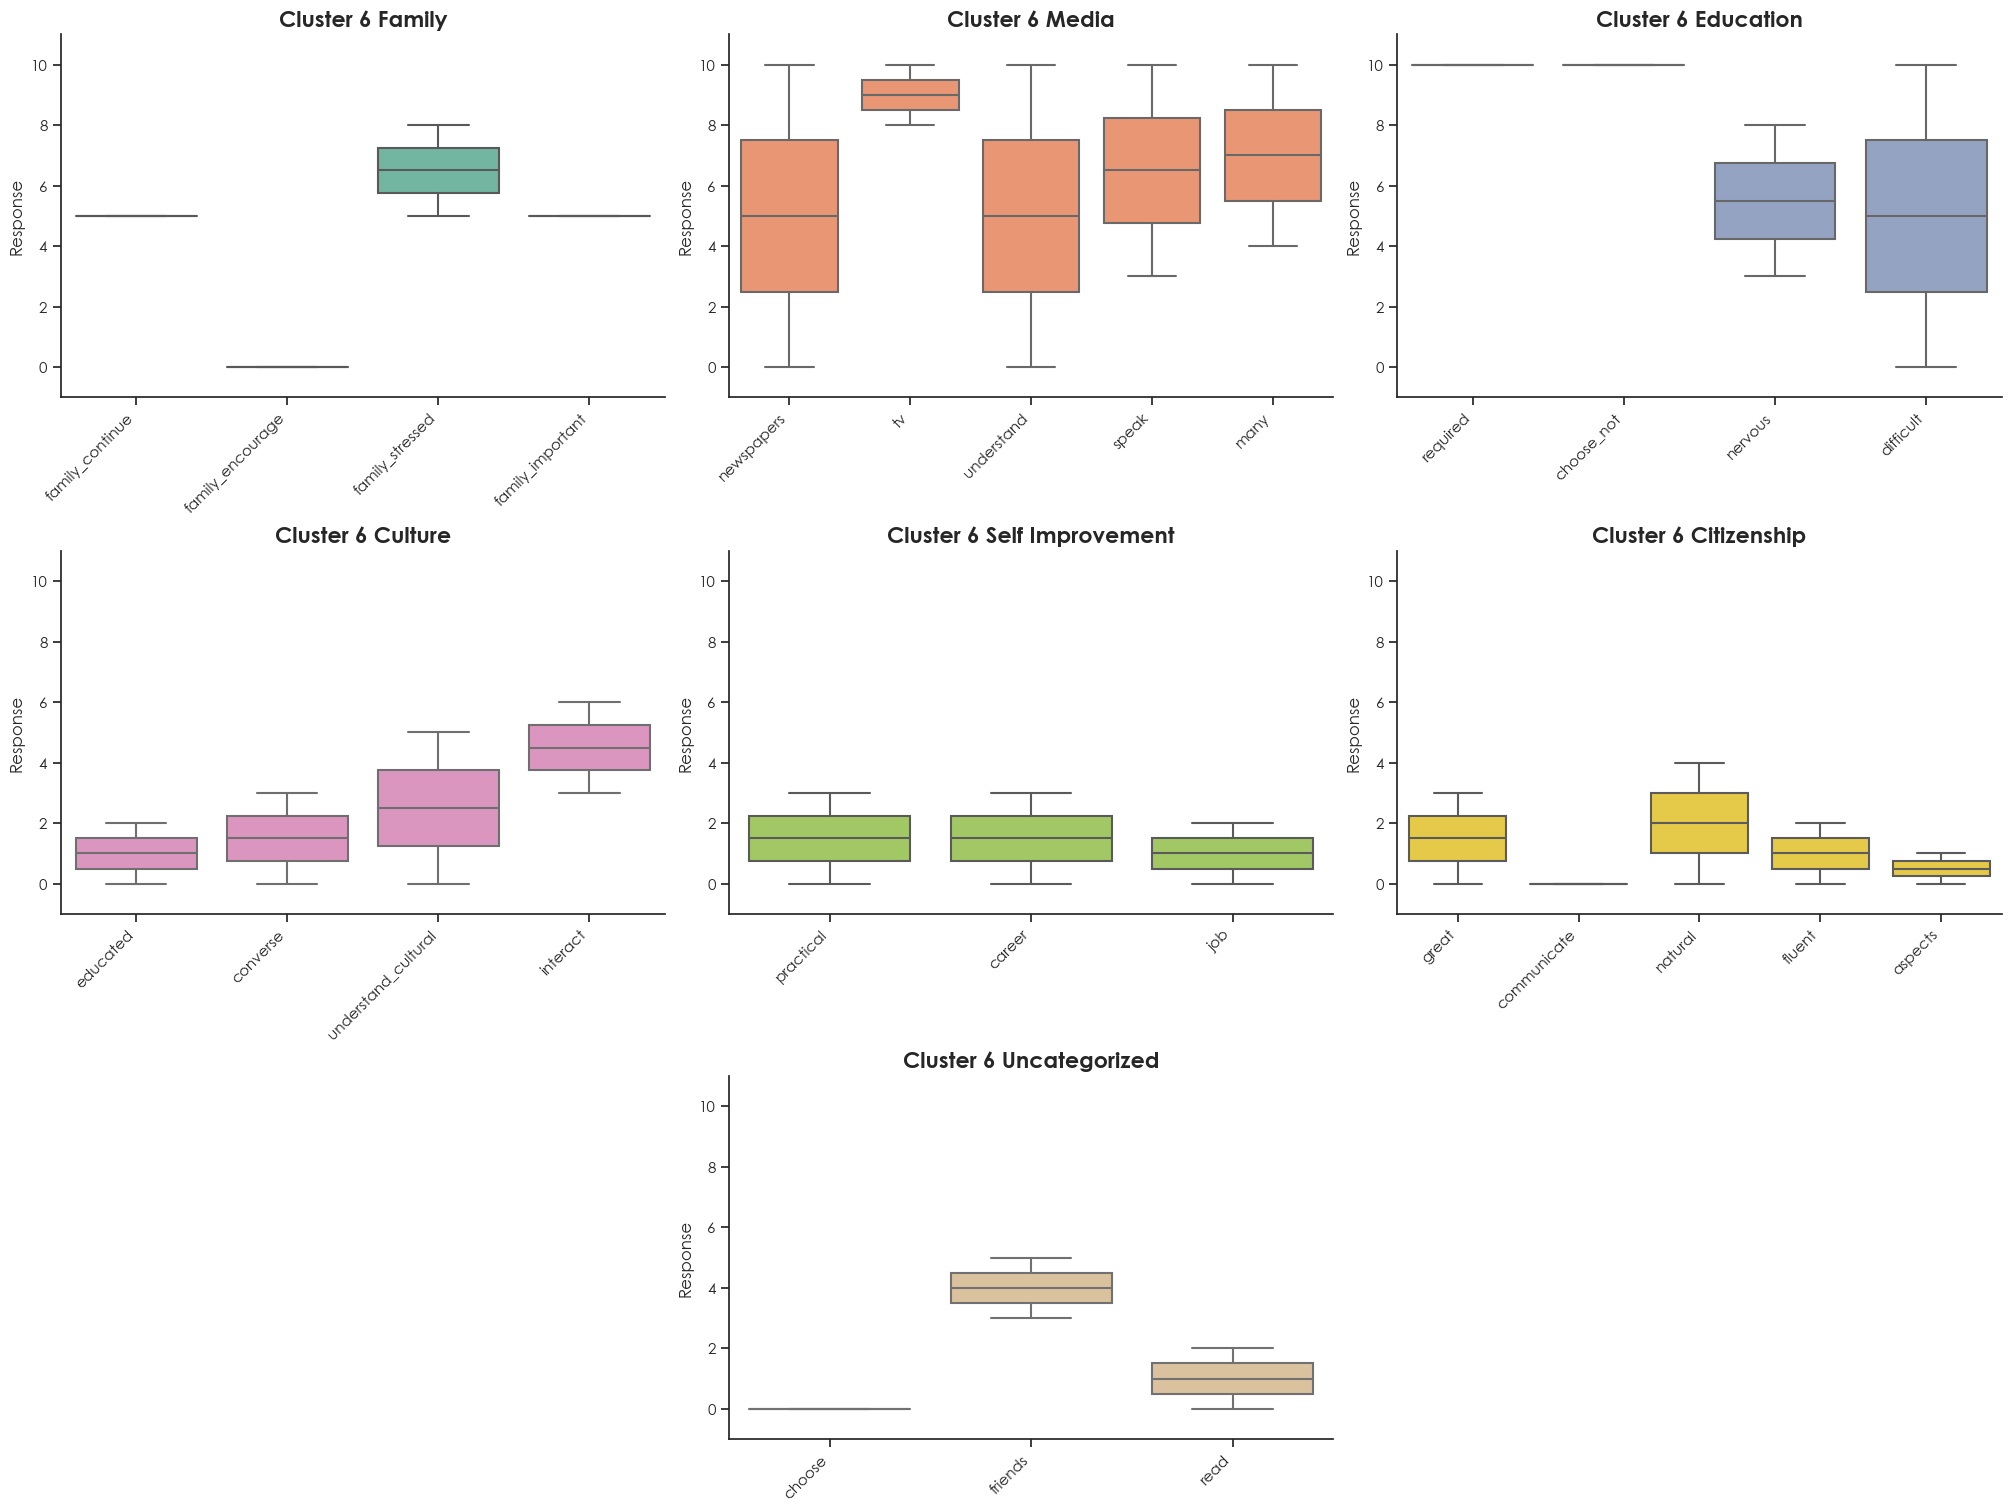

In [158]:
# Create the figures for cluster 6
fig, ax = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)

makeBoxplots(orig_df, family_motives, 6, 'Cluster 6 Family', ax[0][0], color=family_color)
makeBoxplots(orig_df, media_motives, 6, 'Cluster 6 Media', ax[0][1], color=media_color)
makeBoxplots(orig_df, education_motives, 6, 'Cluster 6 Education', ax[0][2], color=education_color)
makeBoxplots(orig_df, culture_motives, 6, 'Cluster 6 Culture', ax[1][0], color=culture_color)
makeBoxplots(orig_df, self_improve_motives, 6, 'Cluster 6 Self Improvement', ax[1][1], color=improvement_color)
makeBoxplots(orig_df, citizenship_motives, 6, 'Cluster 6 Citizenship', ax[1][2], color=citizenship_color)
makeBoxplots(orig_df, uncategorized_motives, 6, 'Cluster 6 Uncategorized', ax[2][1], color=other_color)
ax[2][0].axis('off')
ax[2][2].axis('off')

plt.show()

## Covariance Matrix
---
The covariance matrix is part of the PCA which is the correlation of each feature (motivator) to each other. Values along the diagonal are meaningless. Higher numbers (deeper colors) mean more correlated, and color temperature represents direction. Warmer means positively correlated, cooler means negatively correlated.

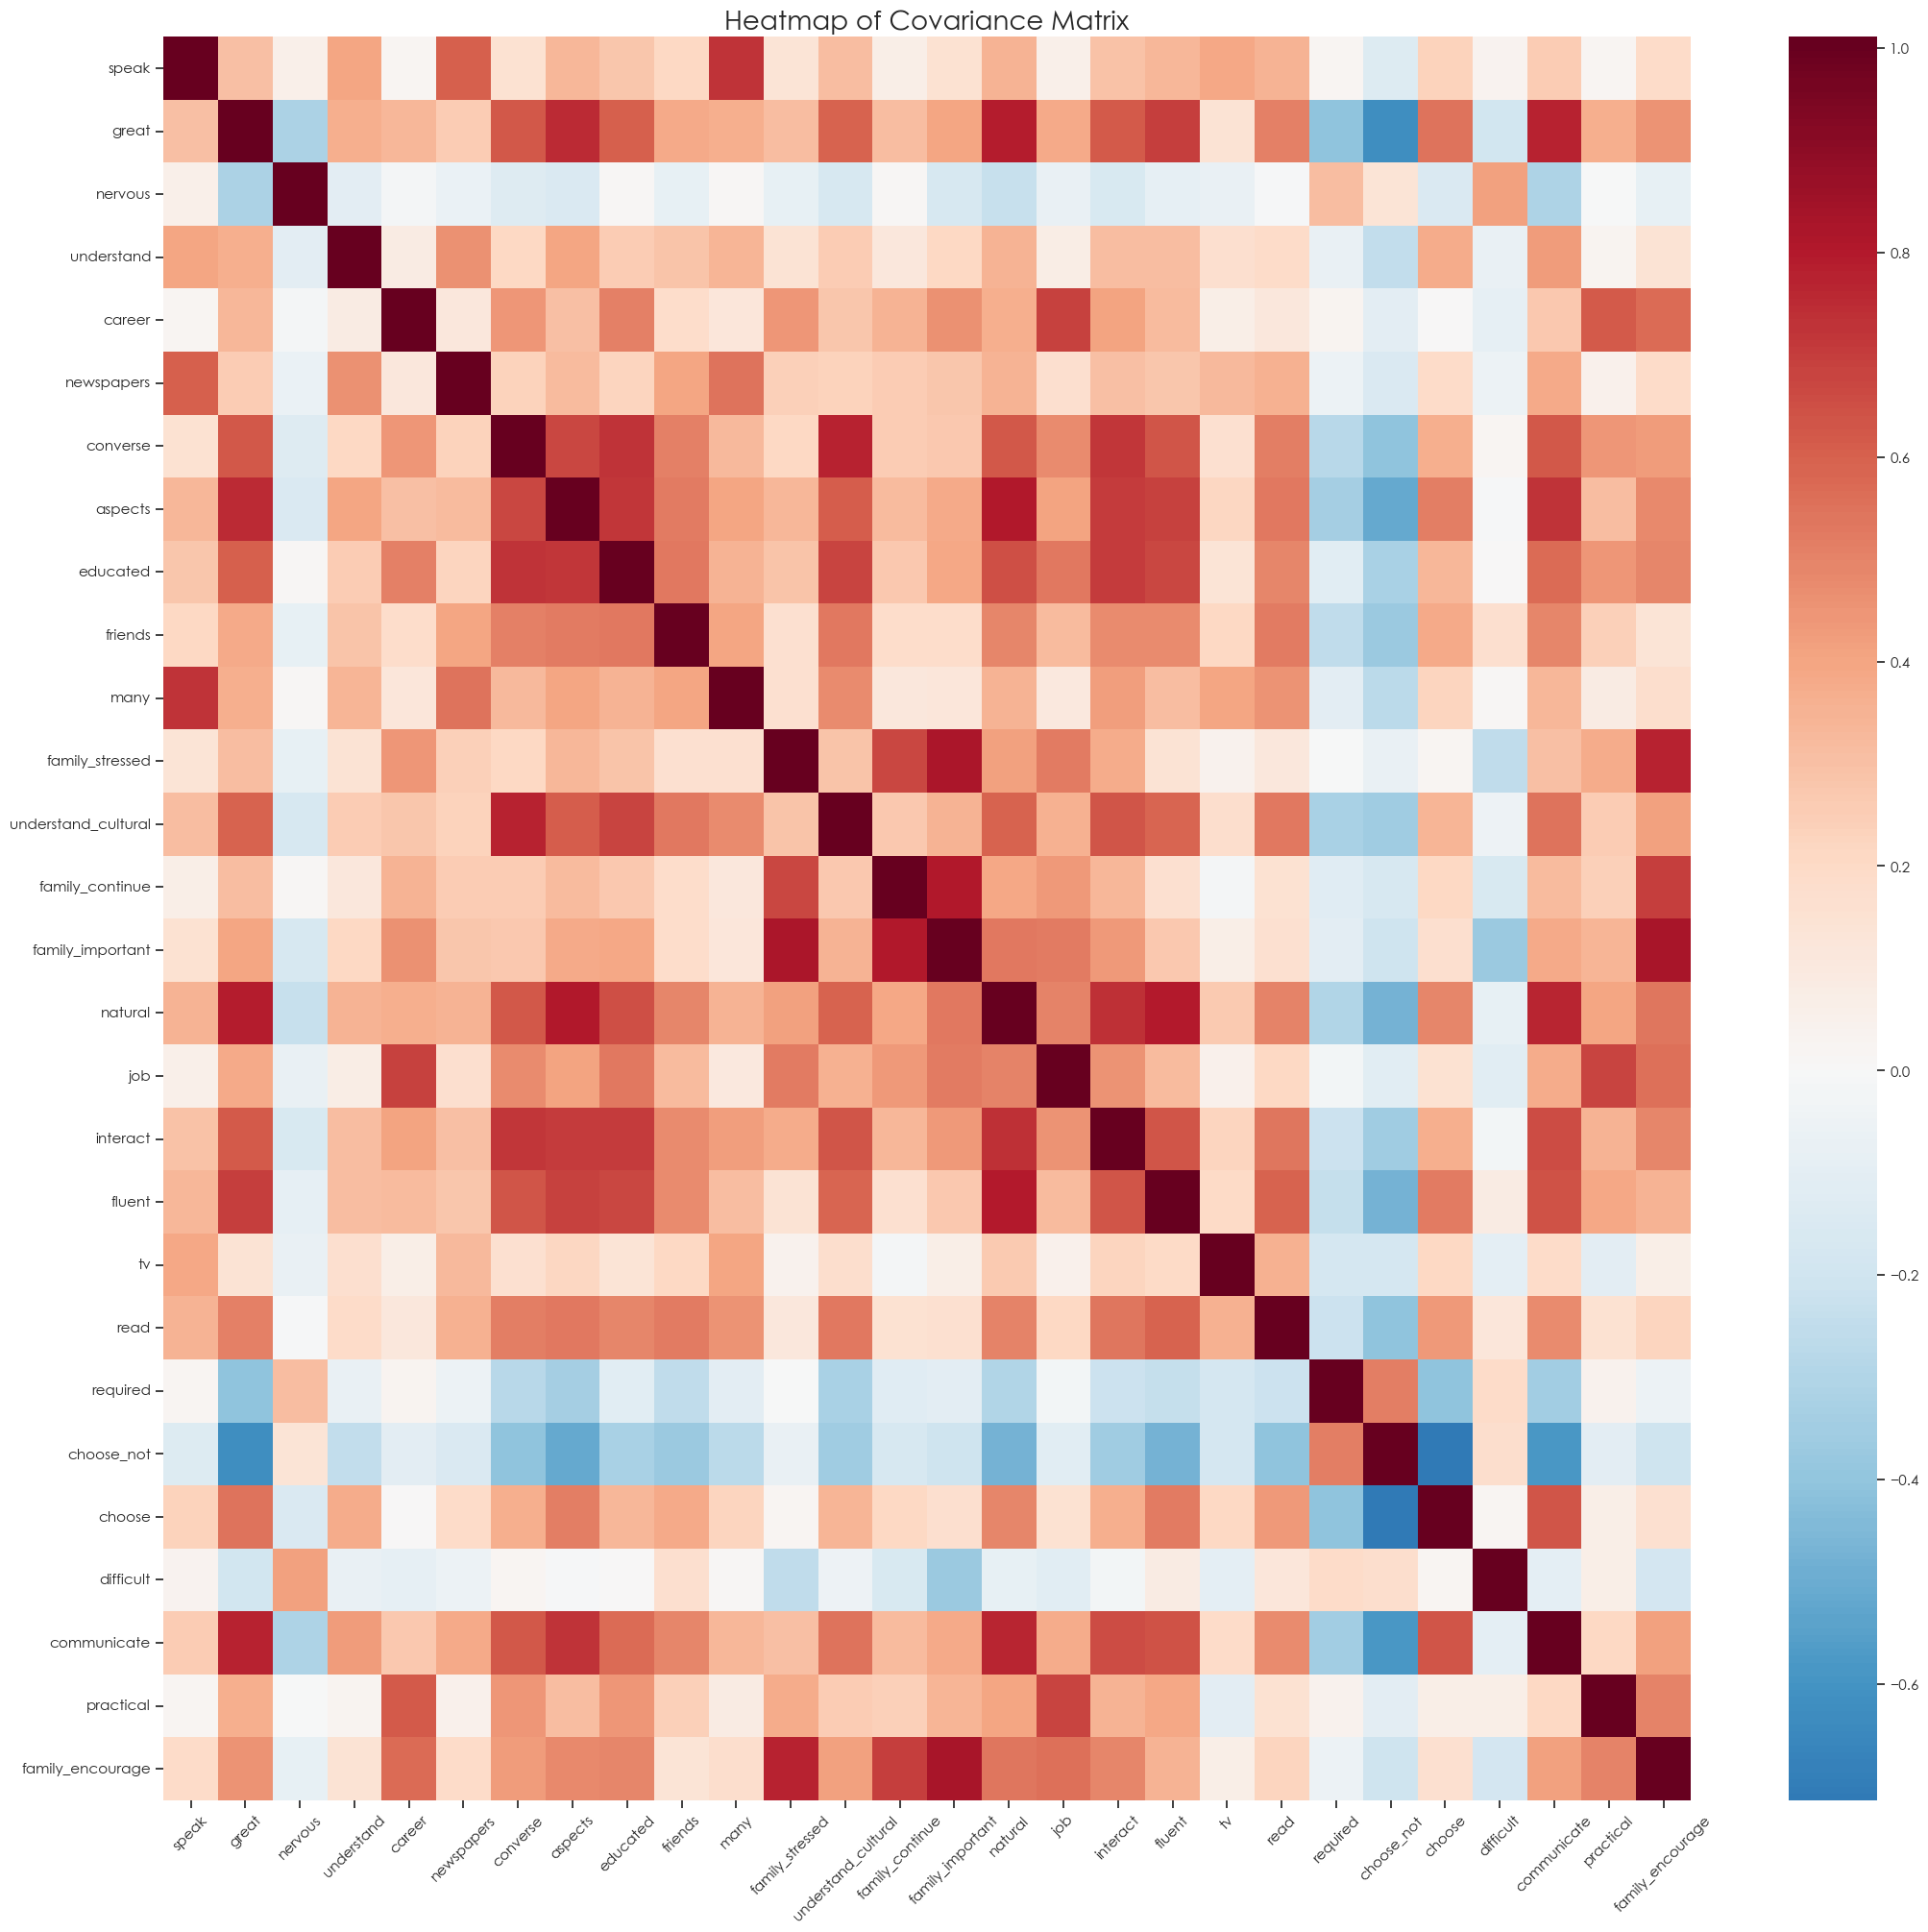

In [159]:
# Generate a heatmap of the covariance matrix
fig, ax = plt.subplots(figsize=(20, 20), constrained_layout=True)

cov_matrix = np.cov(motivators_scaled.T)

sns.heatmap(pd.DataFrame(cov_matrix, columns=short_motive_names, index=short_motive_names),
            cmap='RdBu_r', center=0, ax=ax)

plt.xticks(rotation=45)
plt.title('Heatmap of Covariance Matrix', fontsize=20)
plt.show()

In [160]:
# Go over the column of the covariance matrix and find the columns with the highest covariance
cov_df = pd.DataFrame(cov_matrix, columns=short_motive_names, index=short_motive_names)
cov_df = cov_df.unstack().reset_index()
cov_df.columns = ['Variable 1', 'Variable 2', 'Covariance']
cov_df['Covariance'] = cov_df['Covariance']
cov_df.sort_values(by='Covariance', ascending=False, inplace=True)
cov_df = cov_df[cov_df['Variable 1'] != cov_df['Variable 2']]
cov_df.drop_duplicates(subset='Covariance', inplace=True)

# Reset the index
cov_df.reset_index(drop=True, inplace=True)

# Drop all the rows with a covariance under 0.5
cov_df = cov_df[cov_df['Covariance'].abs() > 0.6]

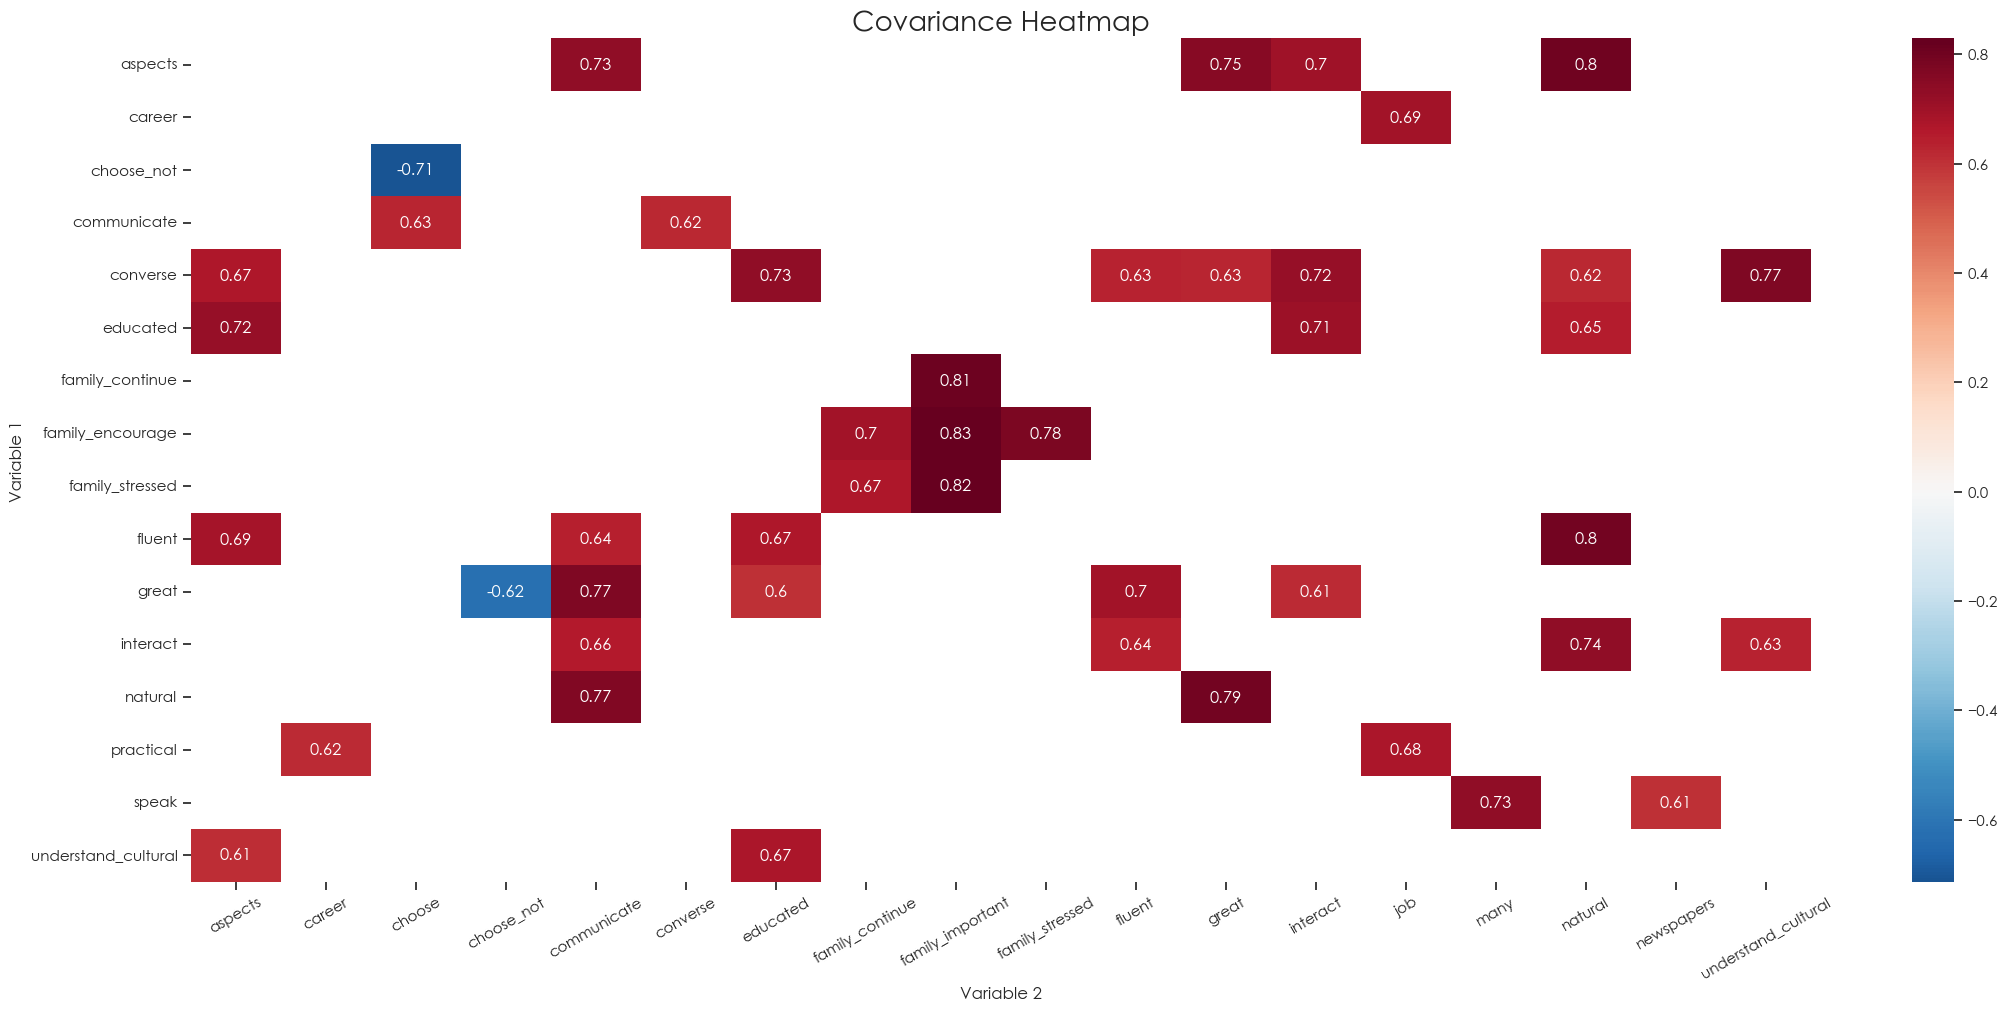

In [161]:
# Graph the covariance dataframe
fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)

# Pivot the DataFrame to have Variable 1 as rows and Variable 2 as columns
pivot_df = cov_df.pivot(index='Variable 1', columns='Variable 2', values='Covariance')

sns.heatmap(pivot_df, annot=True, cmap='RdBu_r', center=0)

# Have the x-axis labels be tilted
plt.xticks(rotation=30)

plt.title('Covariance Heatmap', fontsize=20)
plt.show()

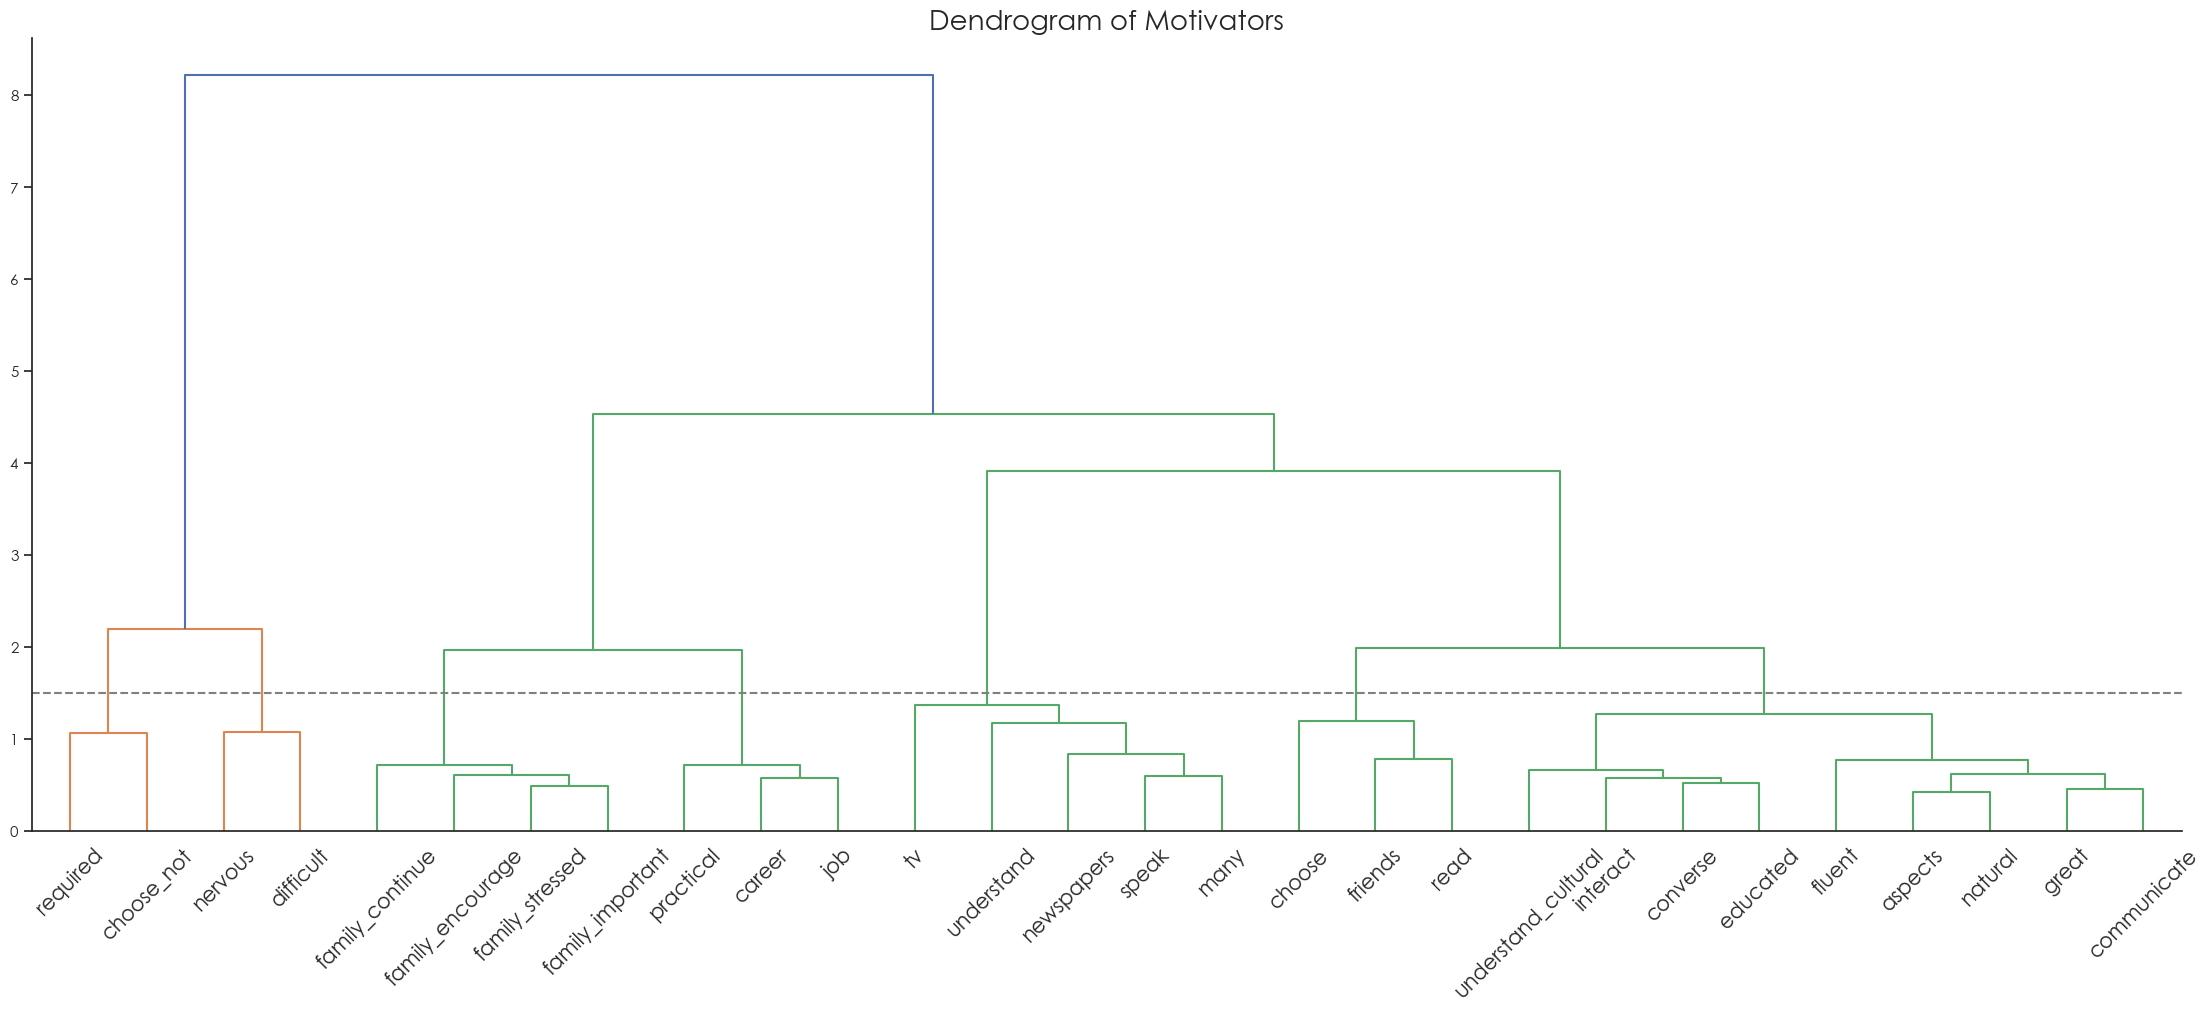

In [162]:
custom_style = {"axes.spines.right": False, "axes.spines.top": False, 
                "font.family": ['sans-serif'], "font.sans-serif": ['Century Gothic']}
sns.set_style("ticks", rc=custom_style)

# Generate a hierarchical clustering model from the covariance matrix
cov_hc = linkage(cov_matrix, method='ward')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(22, 10), constrained_layout=True)
dendrogram(cov_hc, labels=short_motive_names, ax=ax)

# Add a horizontal line at y = 1.5
plt.axhline(y=1.5, color='grey', linestyle='--')

# Set the font size of the x tick labels
plt.xticks(fontsize=15)

plt.title('Dendrogram of Motivators', fontsize=20)
plt.show()

In [163]:
def generate_heatmap(cluster: pd.DataFrame, 
                     ax: plt.Axes, 
                     cluster_label: str, 
                     motivator_list: list[str],
                     show_ylabel: bool = True):
    """
    Generates a heatmap of the correlation matrix of the cluster
    
    Parameters
    ----------
    cluster (pd.DataFrame): The cluster to generate the heatmap for
    ax (plt.Axes): The axis to plot the heatmap on
    """
    global rank_cols

    # Drop the rows that are not motivators
    cluster = cluster.drop(rank_cols, axis=0)

    # Drop the columns that are not ranks
    cluster = cluster.drop(motivator_list, axis=1)
    
    # Remove "motivator_" from the index
    cluster.index = cluster.index.str.replace('motivator_', '')

    # Remove "rank_" from the columns
    cluster.columns = cluster.columns.str.replace('rank_', '')

    # Generate the heatmap
    sns.heatmap(cluster, cmap='RdBu_r', center=0, annot=True, ax=ax, 
                linewidth=0.8, 
                vmin=-0.6, vmax=0.6)
    
    # Set the y-axis labels to be horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Set the title of the heatmap
    ax.set_title(f"{cluster_label}", fontsize=20, weight='bold')
    #ax.set_xlabel('Rank', fontsize=15)
    if show_ylabel:
        ax.set_ylabel('Motivator', fontsize=15)

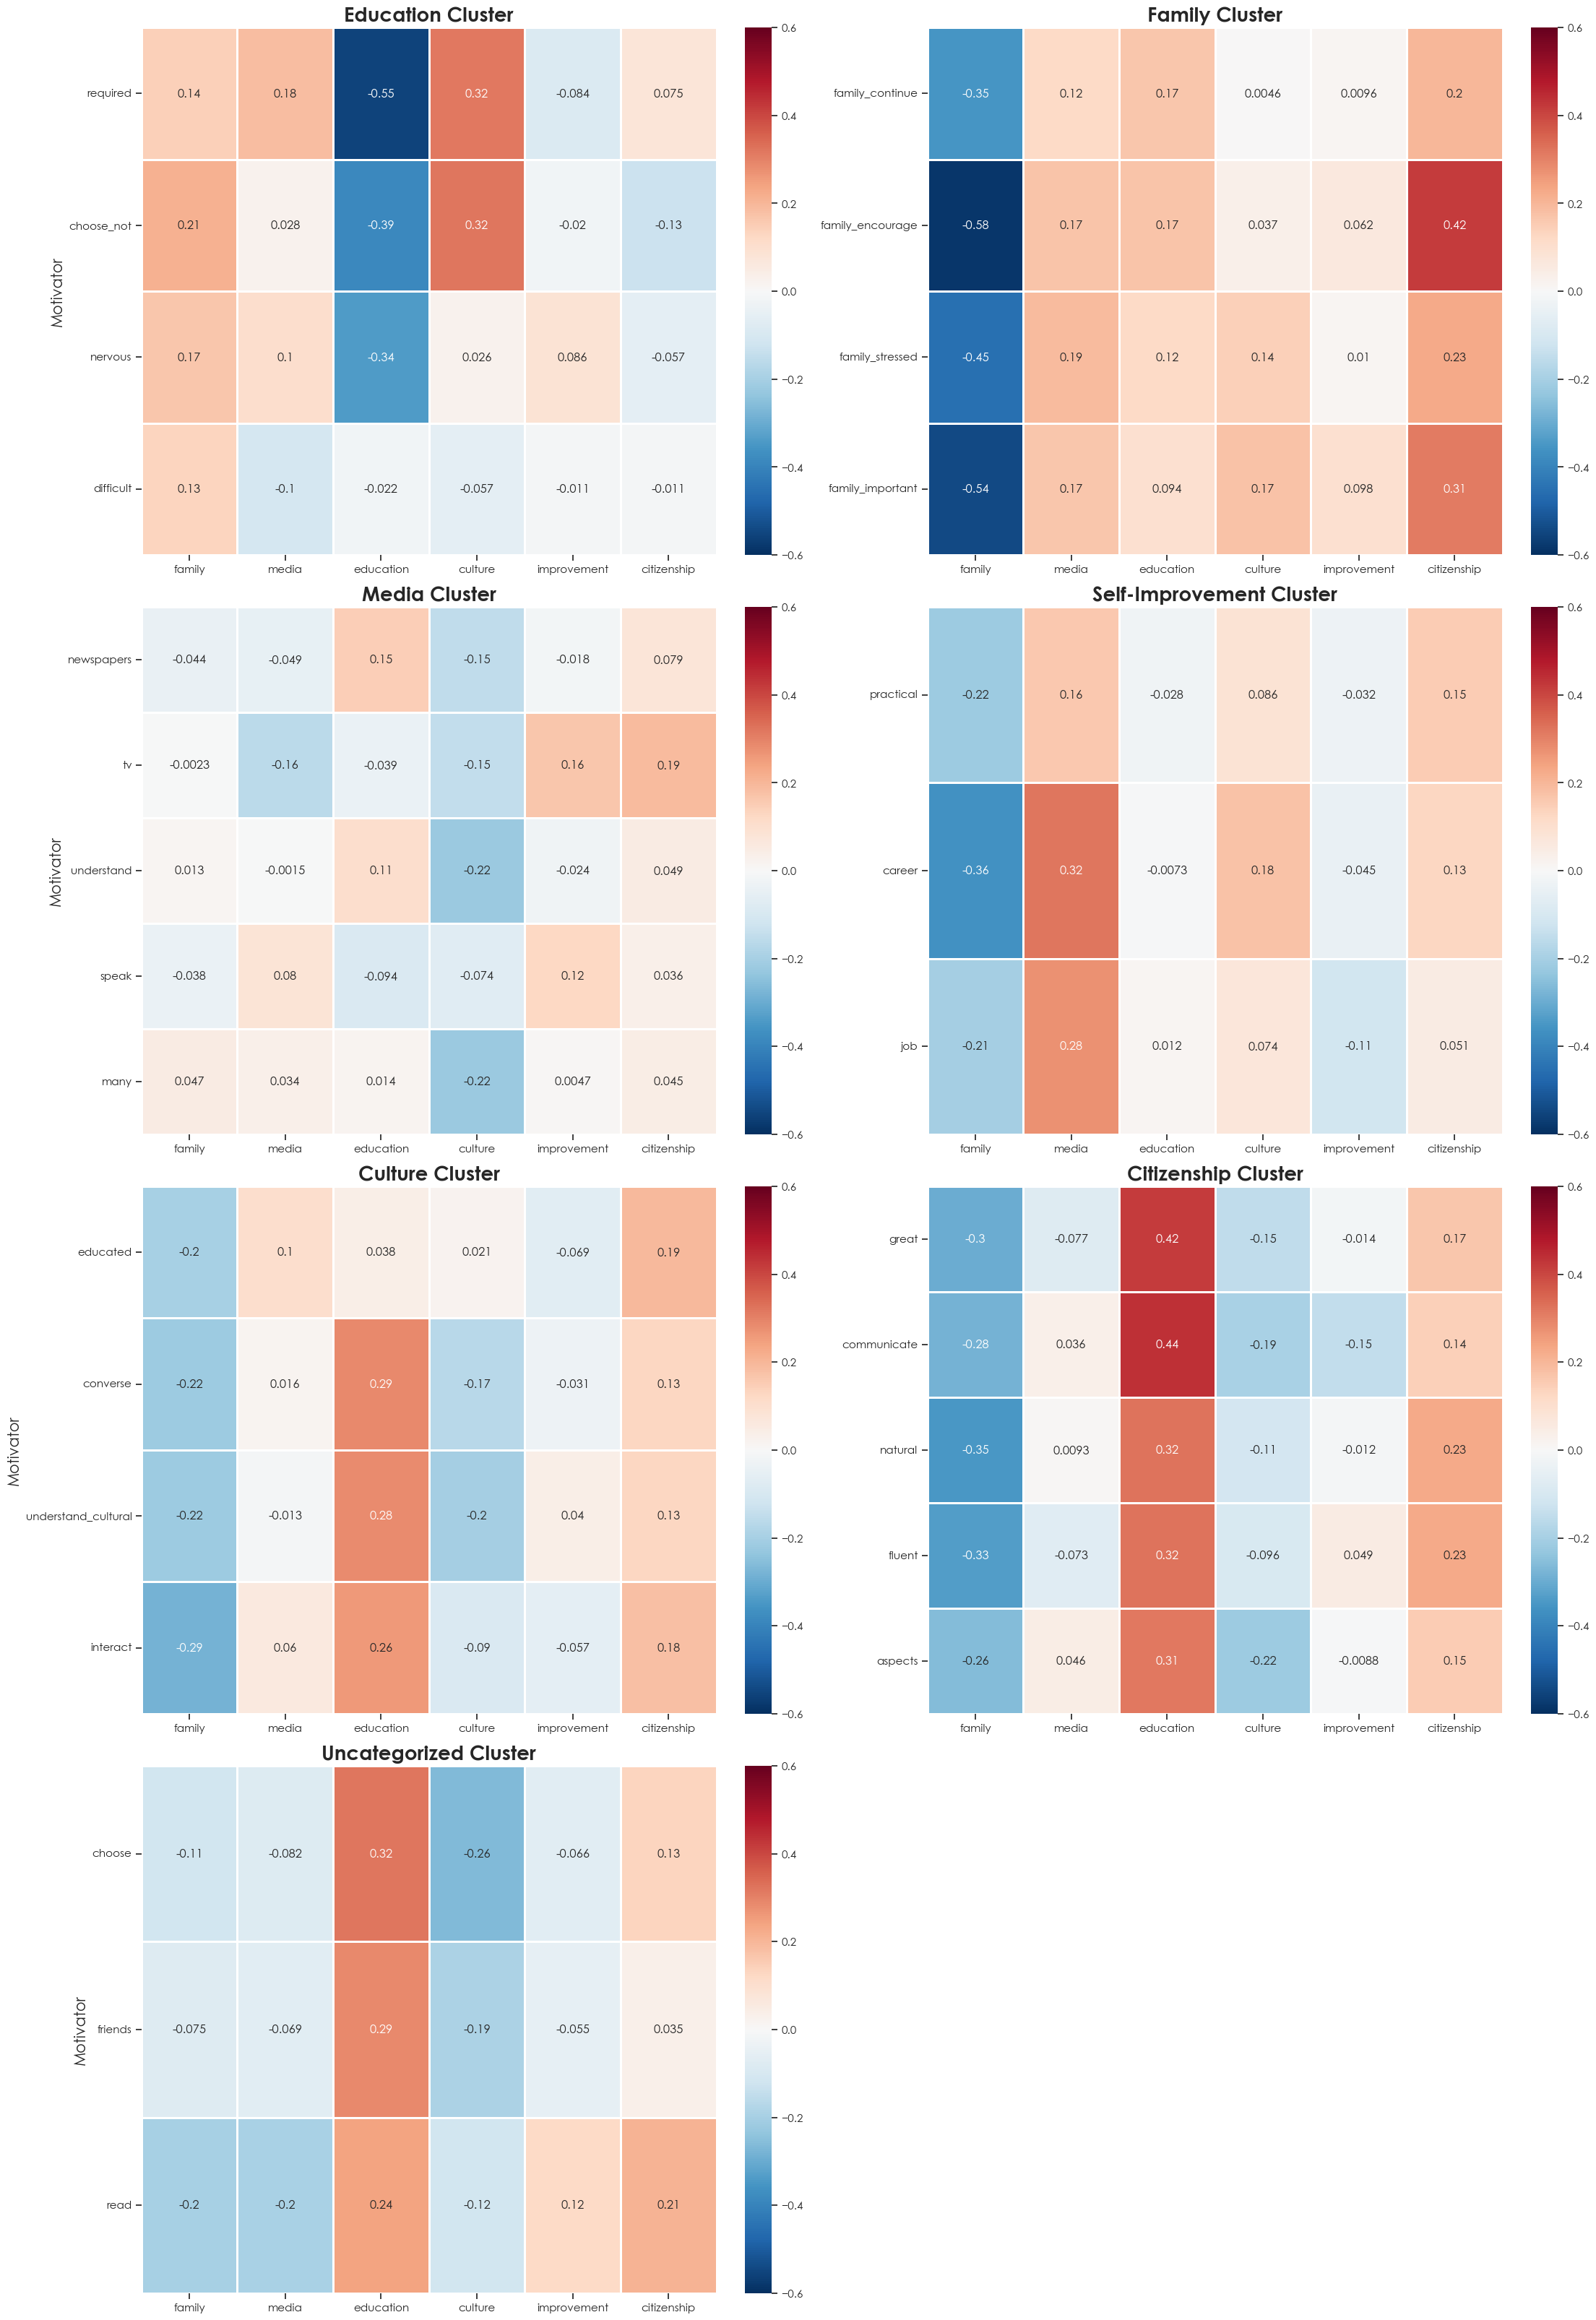

In [164]:
# Calculate the correlation of "required, choose_not, nervous, and difficult" to motivator ranks
rank_cols = df.columns[df.columns.str.contains('rank')].tolist()

# Generate the correlation semi-matrices
education_df    = df[rank_cols + education_motives].corr()
family_df       = df[rank_cols + family_motives].corr()
media_df        = df[rank_cols + media_motives].corr()
self_improve_df = df[rank_cols + self_improve_motives].corr()
culture_df      = df[rank_cols + culture_motives].corr()
citizenship_df  = df[rank_cols + citizenship_motives].corr()
uncategorized_df = df[rank_cols + uncategorized_motives].corr()

# Compute the heatmap
fig, ax = plt.subplots(4, 2, figsize=(22, 32), constrained_layout=True)
#second_fig, second_ax = plt.subplots(1, 2, figsize=(22, 8), constrained_layout=True)
#third_fig, third_ax = plt.subplots(1, 2, figsize=(22, 8), constrained_layout=True)

generate_heatmap(education_df, ax[0][0], 'Education Cluster', education_motives)
generate_heatmap(family_df, ax[0][1], 'Family Cluster', family_motives, show_ylabel=False)
generate_heatmap(media_df, ax[1][0], 'Media Cluster', media_motives)
generate_heatmap(self_improve_df, ax[1][1], 'Self-Improvement Cluster', self_improve_motives, show_ylabel=False)
generate_heatmap(culture_df, ax[2][0], 'Culture Cluster', culture_motives)
generate_heatmap(citizenship_df, ax[2][1], 'Citizenship Cluster', citizenship_motives, show_ylabel=False)
generate_heatmap(uncategorized_df, ax[3][0], 'Uncategorized Cluster', uncategorized_motives)

# Plot an empty space for the last axes
ax[3][1].axis('off')

plt.show()

### Short Interpretation
---
Just from a quick glance, there is not that much correlation between each question with the rank of the motivators they were thought to encapsulate. More statistical testing needed as detailed below.

In [165]:
def printPValues(cluster: pd.DataFrame) -> list[str]:
    """
    Prints the p-values of the correlation between the motivators and the ranks.

    Parameters
    ----------
    cluster : pd.DataFrame

    Returns
    -------
    list[str]: A list of strings that contain the p-values of the correlation between the motivators and the ranks.
    """
    global rank_cols
    p_values = []

    # Add 'motivator_' to the front of the index
    motivators = cluster.drop(rank_cols, axis=0).index
    # Add 'rank_' to the front of the columns
    ranks = cluster.drop(motivators, axis=1).columns
    for motive in motivators.tolist():
        for rank in ranks.tolist():
            _, p_value = pearsonr(df[motive], df[rank])
            if p_value < 0.05:
                #p_values.append(f'{motive} and {rank} have a p-value of {p_value:.3f}')
                p_values.append("%-29s | %-18s %-10s %.3f" % (motive, rank, '| p-value', p_value))
    return p_values

In [166]:
def prettyPrint(list: list[str], title: str): 
    """
    Prints the list in a pretty format.

    Makes a table border around the list.

    Parameters
    ----------
    list : list[str]
    """
    # Create the top line of the table
    # First five characters are dashes
    # Next len(title) characters are the title
    # Remaining characters are dashes
    topLine = '-' * 5 + ' ' + title + ' ' + '-' * (68 - 7 - len(title))

    print(topLine)
    for item in list:
        print(item)
    print('-' * 68)

In [167]:
# Print the p-values of the correlation between the motivators and the ranks
prettyPrint(printPValues(education_df), 'Education Cluster')
#print(*printPValues(education_df), sep="\n")

# Print out a new line
print()

prettyPrint(printPValues(family_df), 'Family Cluster')

# Print out a new line
print()

prettyPrint(printPValues(media_df), 'Media Cluster')

# Print out a new line
print()

prettyPrint(printPValues(self_improve_df), 'Self-Improvement Cluster')

# Print out a new line
print()

prettyPrint(printPValues(culture_df), 'Culture Cluster')

# Print out a new line
print()

prettyPrint(printPValues(citizenship_df), 'Citizenship Cluster')

# Print out a new line
print()

prettyPrint(printPValues(uncategorized_df), 'Uncategorized Cluster')

----- Education Cluster --------------------------------------------
motivator_required            | rank_education     | p-value  0.000
motivator_required            | rank_culture       | p-value  0.002
motivator_choose_not          | rank_family        | p-value  0.039
motivator_choose_not          | rank_education     | p-value  0.000
motivator_choose_not          | rank_culture       | p-value  0.002
motivator_nervous             | rank_education     | p-value  0.001
--------------------------------------------------------------------

----- Family Cluster -----------------------------------------------
motivator_family_continue     | rank_family        | p-value  0.001
motivator_family_encourage    | rank_family        | p-value  0.000
motivator_family_encourage    | rank_citizenship   | p-value  0.000
motivator_family_stressed     | rank_family        | p-value  0.000
motivator_family_stressed     | rank_citizenship   | p-value  0.029
motivator_family_important    | rank_family 